# Data Analysis and Graph

## Import

In [1]:
import re
import numpy as np
import pandas as pd
import requests
from datetime import datetime
from bs4 import BeautifulSoup
import time
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import statsmodels.api as sm
import pylab as pl
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
fl = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family=fl)
%matplotlib inline
warnings.filterwarnings("ignore")

## Naver_crawling Describe

In [2]:
df= pd.read_csv('naver_crawling.csv', index_col=0)
describe= df[(df.지역 == '강서구')]
describe.describe()

,공급면적,전용면적,매물가,현재층범주
count,4284.000000,4284.000000,4284.000000,4284.000000
mean,103.383599,80.275908,73892.203548,2.964052
std,31.370321,26.426001,27820.368223,1.015691
min,19.200000,12.160000,8100.000000,1.000000
25%,80.815000,59.910000,53375.000000,2.000000
50%,105.390000,84.780000,69000.000000,3.000000
75%,114.180000,84.980000,92000.000000,4.000000
max,235.910000,192.220000,199000.000000,5.000000


## Naver_crawling analysis

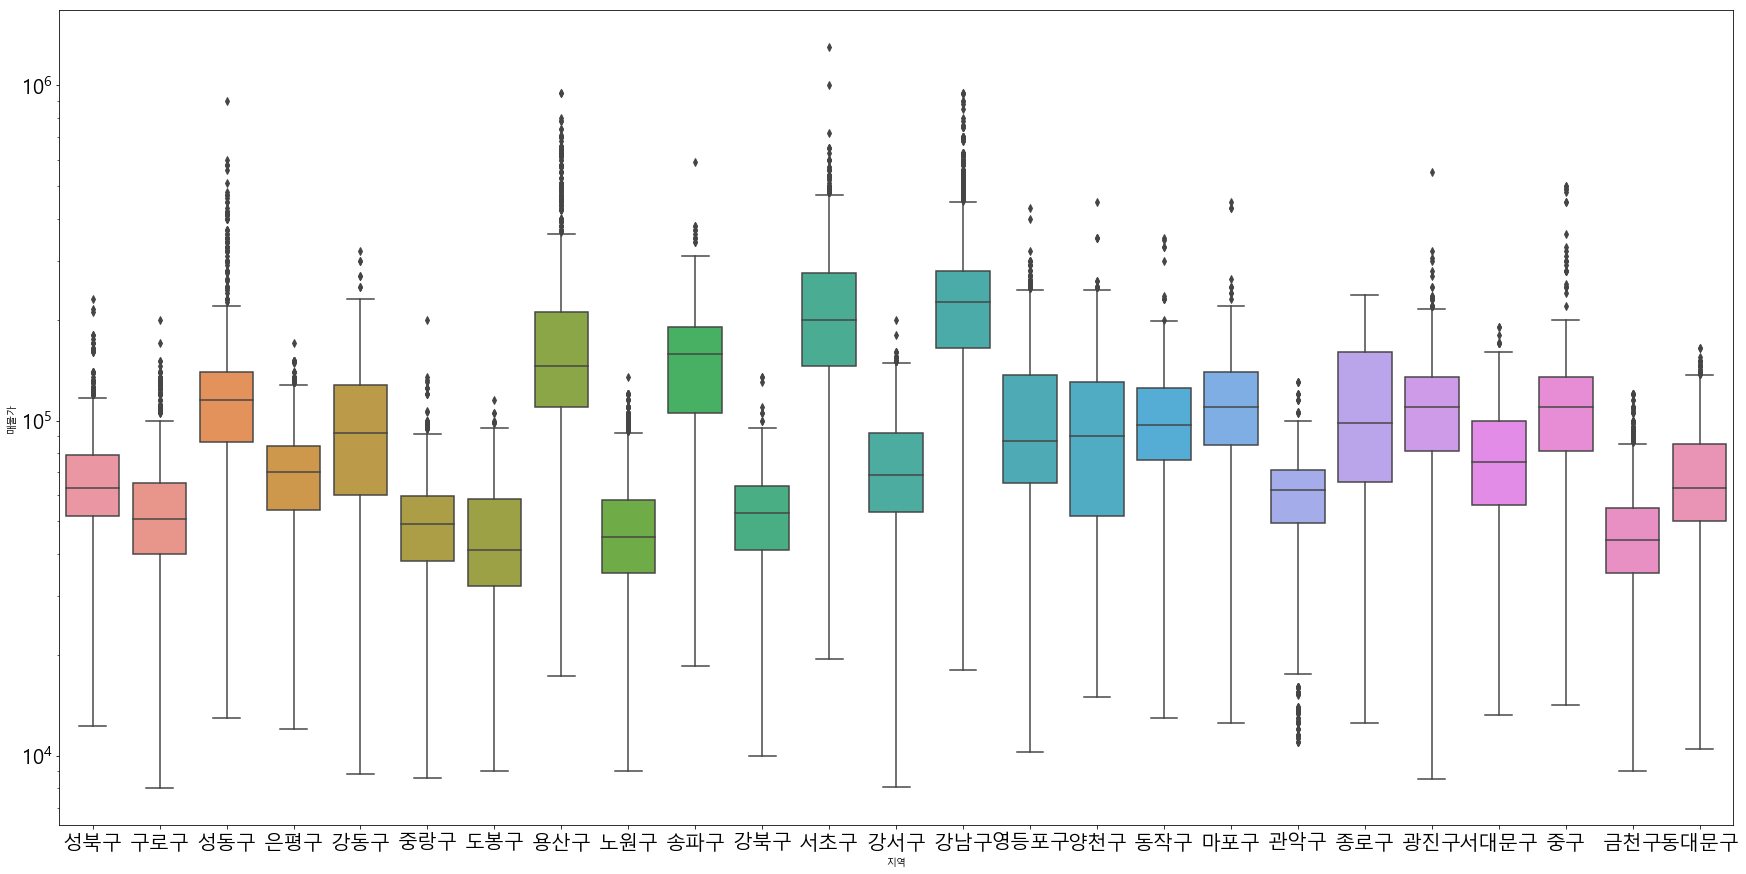

In [4]:
# naver는 네이버부동산 크롤링 데이터 불러온것
naver=pd.read_csv("naver_crawling.csv")
naver.drop(["Unnamed: 0"], axis=1, inplace=True)
#지역별 분포 박스플롯 (x는 지역, y는 집값)
#figsize가 한 번에 실행이 안 될 경우 다시 한 번 실행 할 것!
sns.boxplot(x="지역",y="매물가",data=naver)
plt.rcParams['figure.figsize']=[30,15]
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## Time and Count analysis

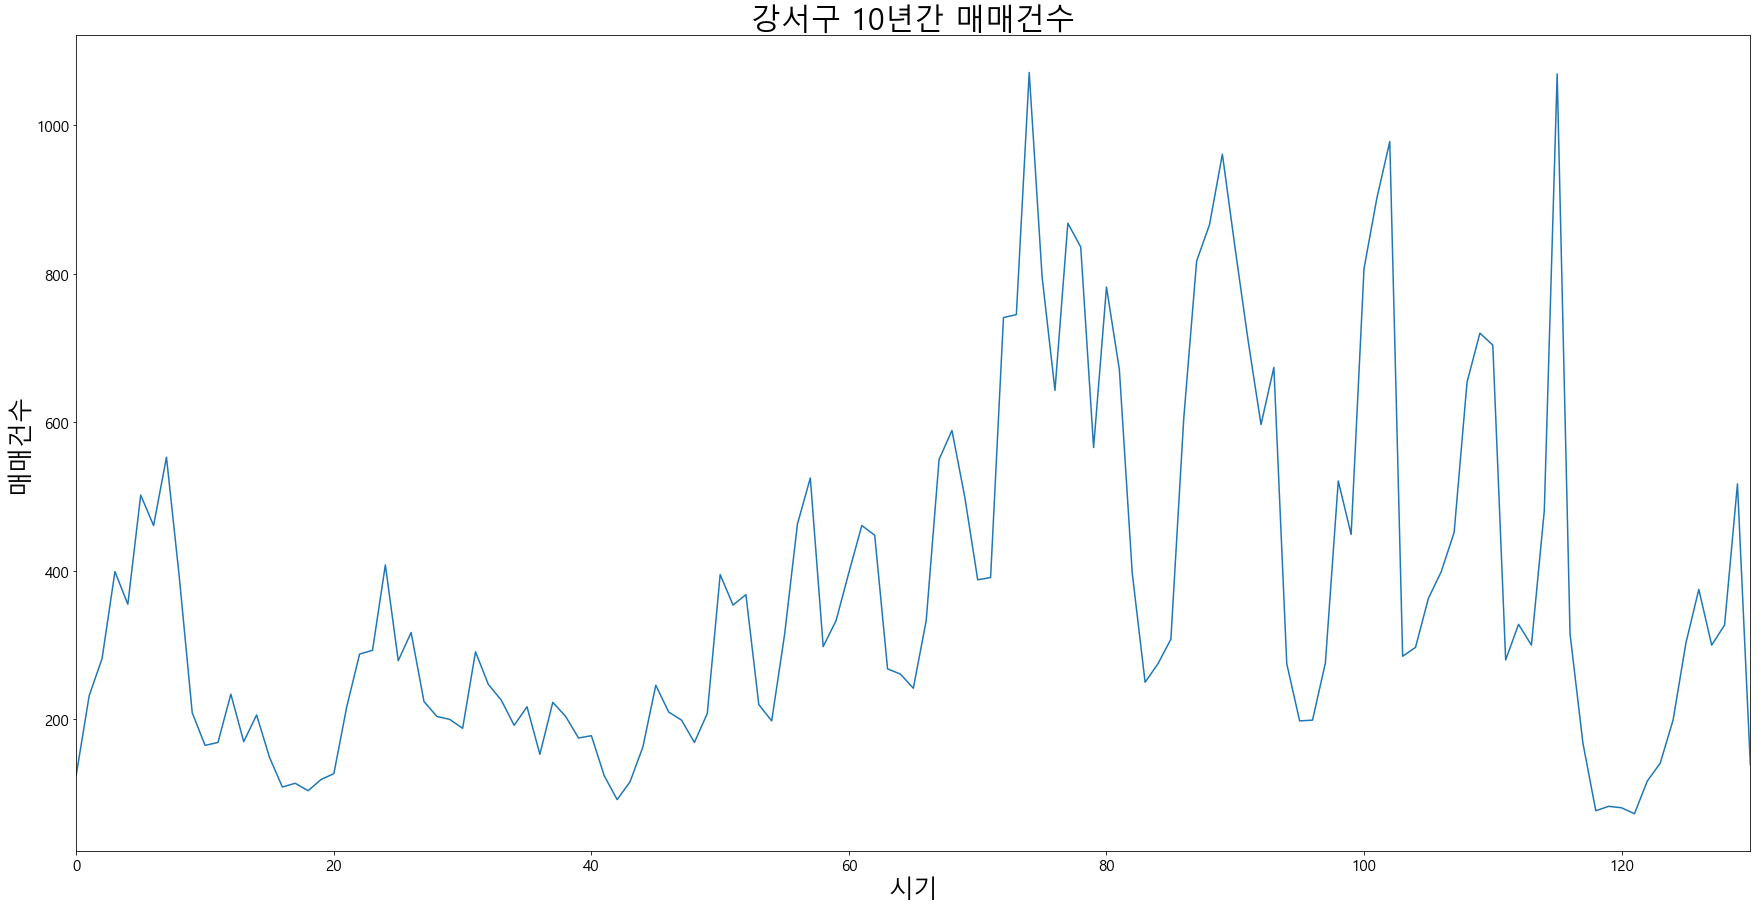

In [5]:
#매매건수 그래프 (시기, 매매건수)
#매매건수 날짜 글자형은 timecount
timecount=pd.read_csv("timecount.csv", index_col=0)
plt.plot(timecount["강서구"])
plt.title("강서구 10년간 매매건수", fontsize=30)  
plt.xticks(fontsize=15)   #rotation=90, 
plt.yticks(fontsize=15)   
plt.xlabel("시기", fontsize=25)
plt.ylabel("매매건수", fontsize=25)
plt.xlim("09년01월","19년11월")
plt.xscale("linear")
#plt.savefig("test.png", dpi=100)
plt.show()

## TSA (time and count)

<Figure size 864x720 with 0 Axes>

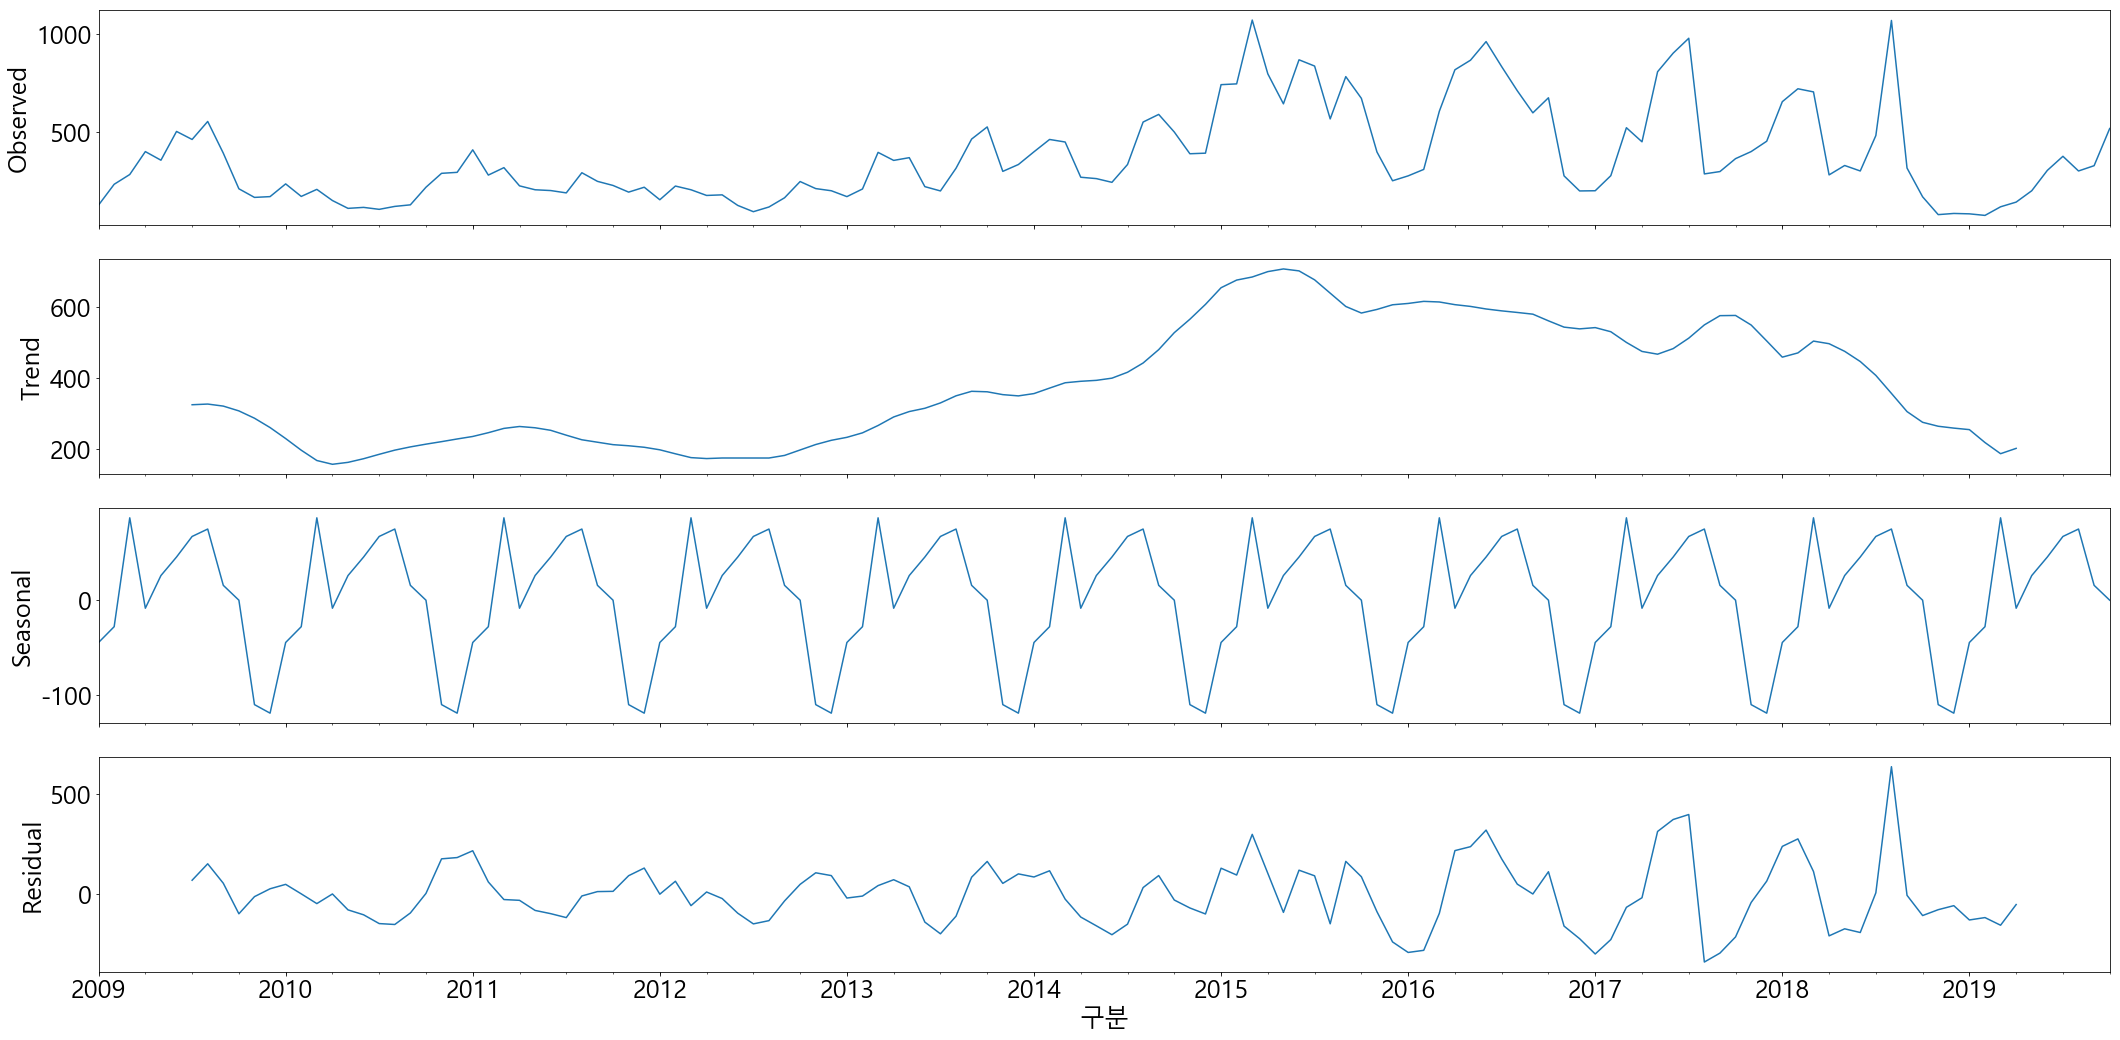

In [6]:
#매매건수 시계열 추세 그래프
timecountnum=pd.read_csv("timecountnum.csv", header=0, index_col=0, squeeze=True)       #매매건수 데이터 읽어오기
timecountnum.reset_index(inplace=True)                        #데이터 인덱스 리셋
timecountnum['구분'] = pd.to_datetime(timecountnum['구분'], format='%Y%m')     #인덱스 년월 날짜식으로 지정
timecountnum = timecountnum.set_index('구분')                          #인덱스 년월 날짜식으로 지정
timecount_tsa= timecountnum["강서구"]                                    
s=sm.tsa.seasonal_decompose(timecount_tsa)  
 #그래프(데이터, 추세요인, 계절요인, 불규칙요인) 그리기 (분해시계열!!)
matplotlib.rcParams['axes.unicode_minus'] = False 
plt.rc('font',size=25)
plt.figure(figsize=(12,10))
s.plot()
plt.savefig("./image/강서구/gangseo_count_tsa.png", dpi=100)
plt.show()

## acf and pacf

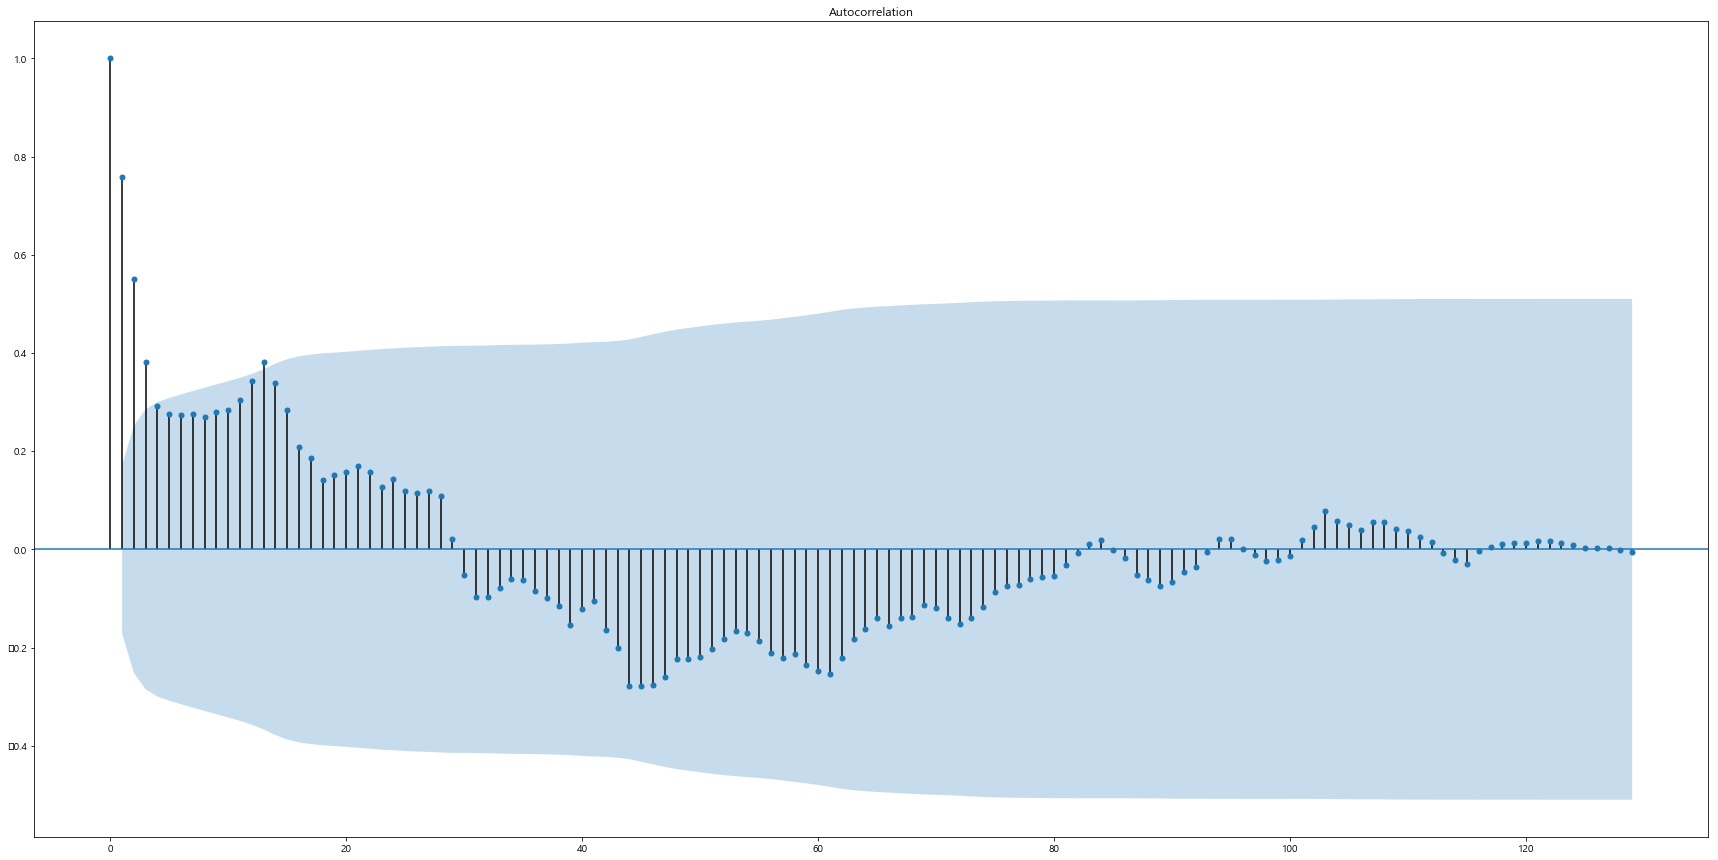

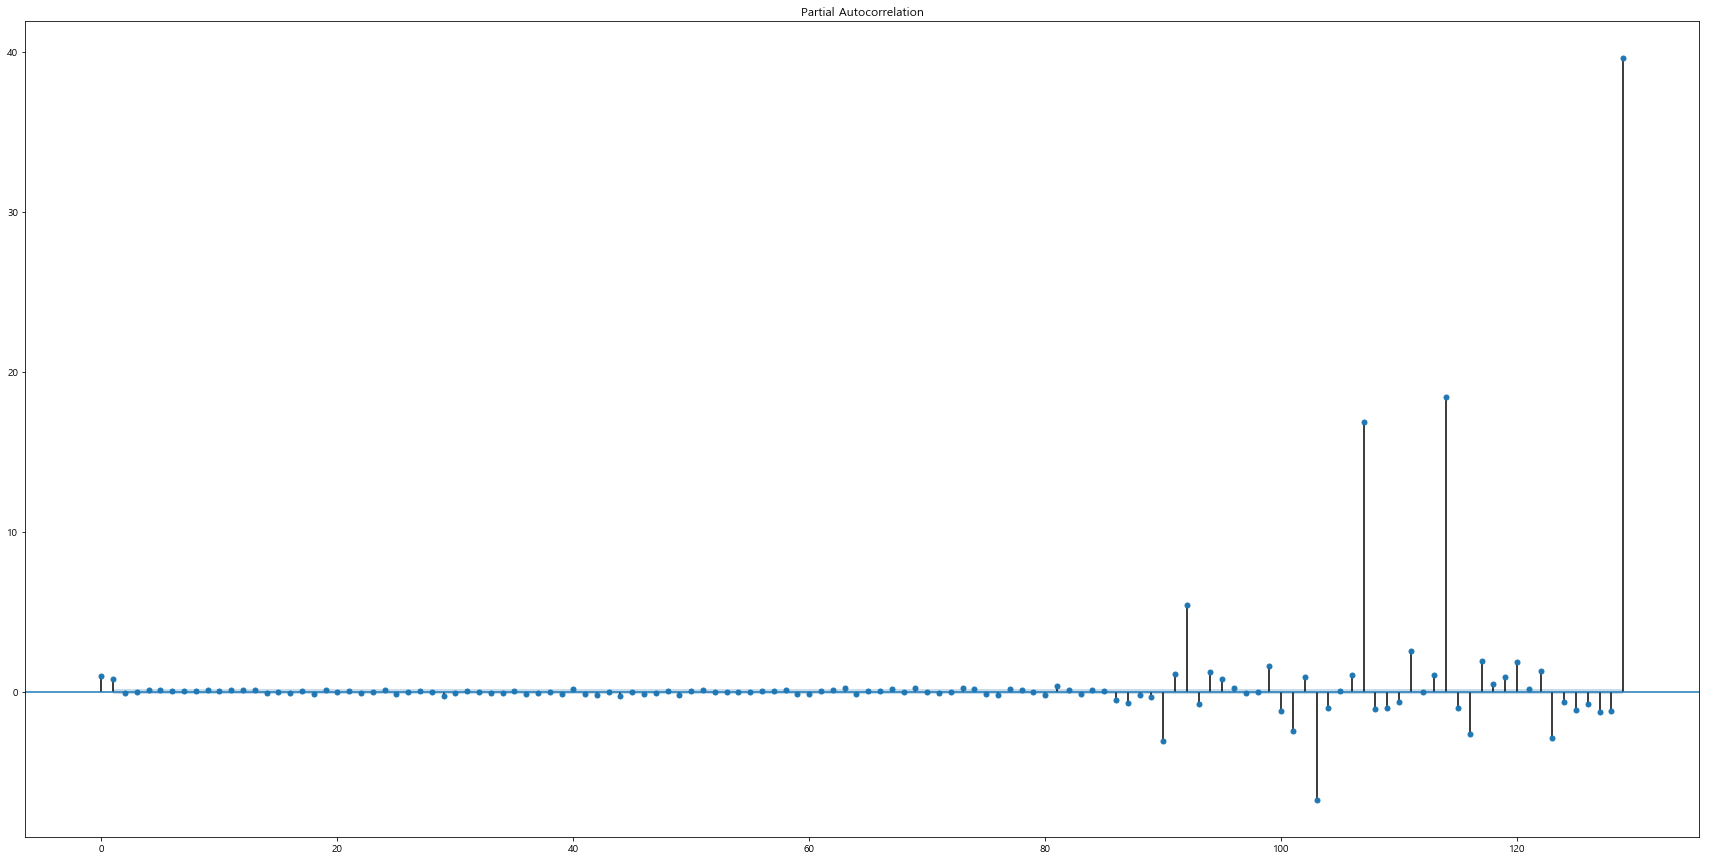

In [8]:
plot_acf(timecount_tsa)    #acf 그래프 (자기상관함수)
plot_pacf(timecount_tsa)   #pacf 그래프 (부분자기상관함수)
plt.show()

## First Differencing

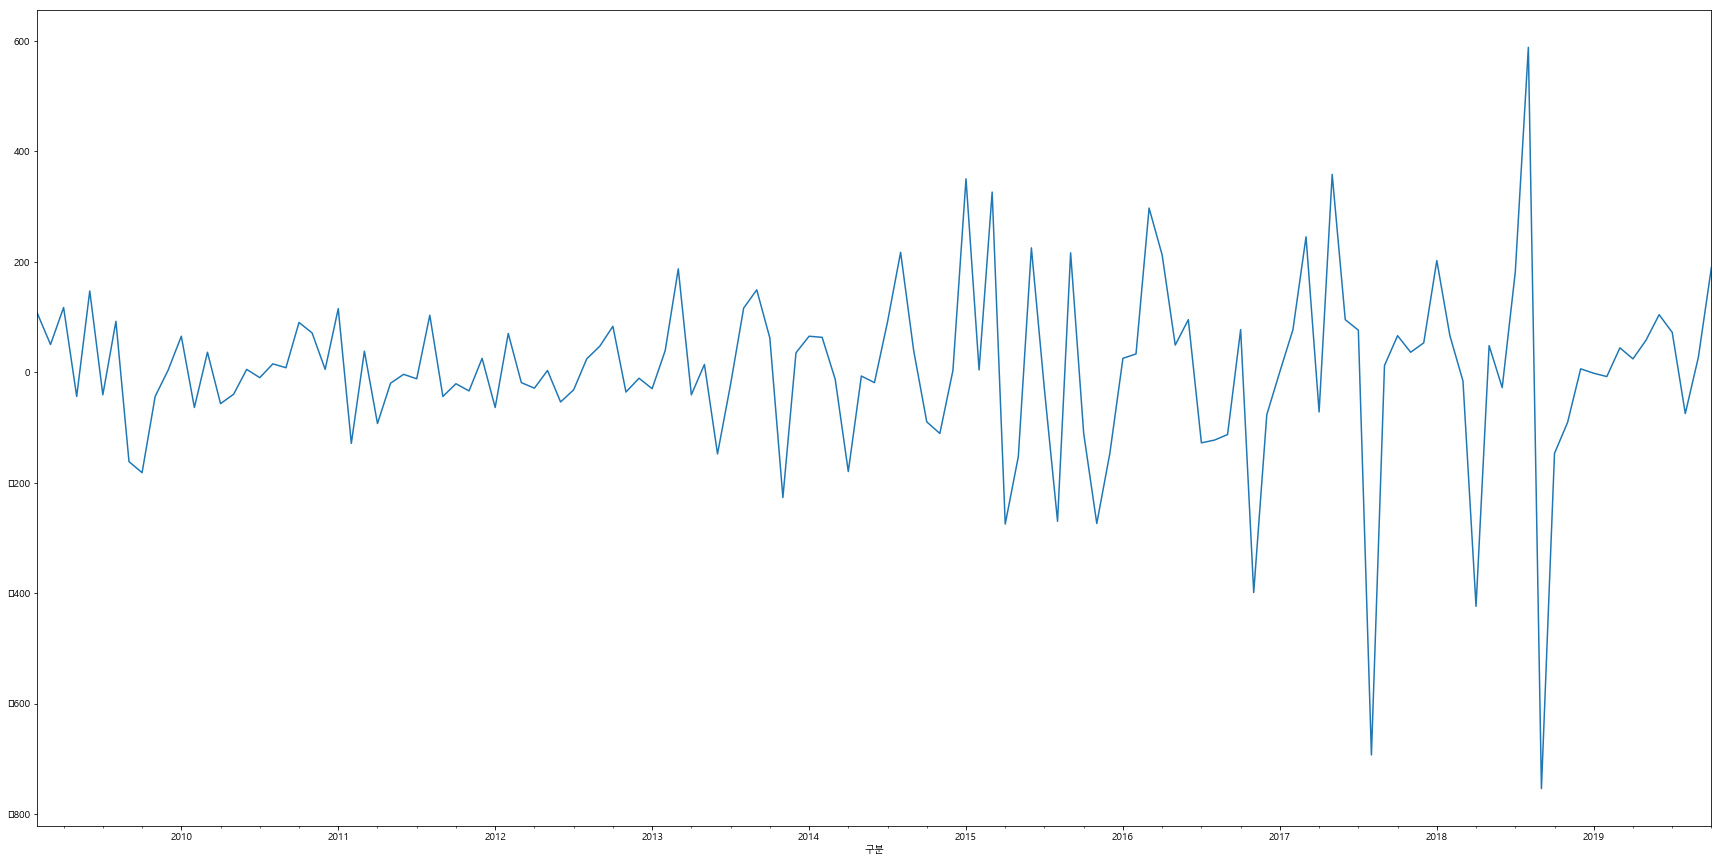

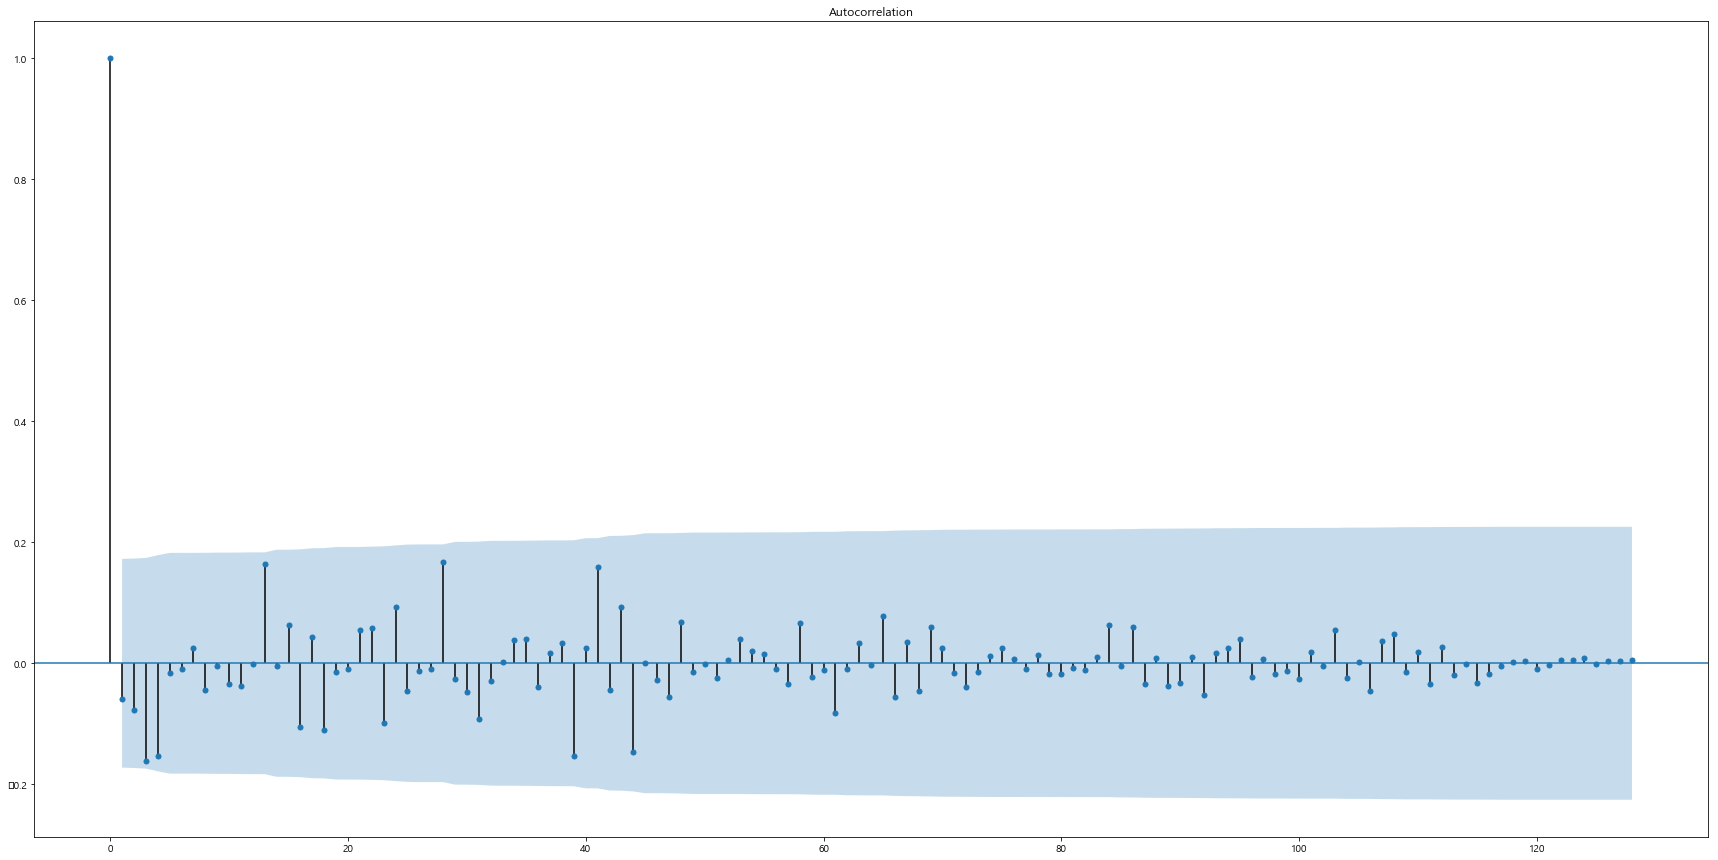

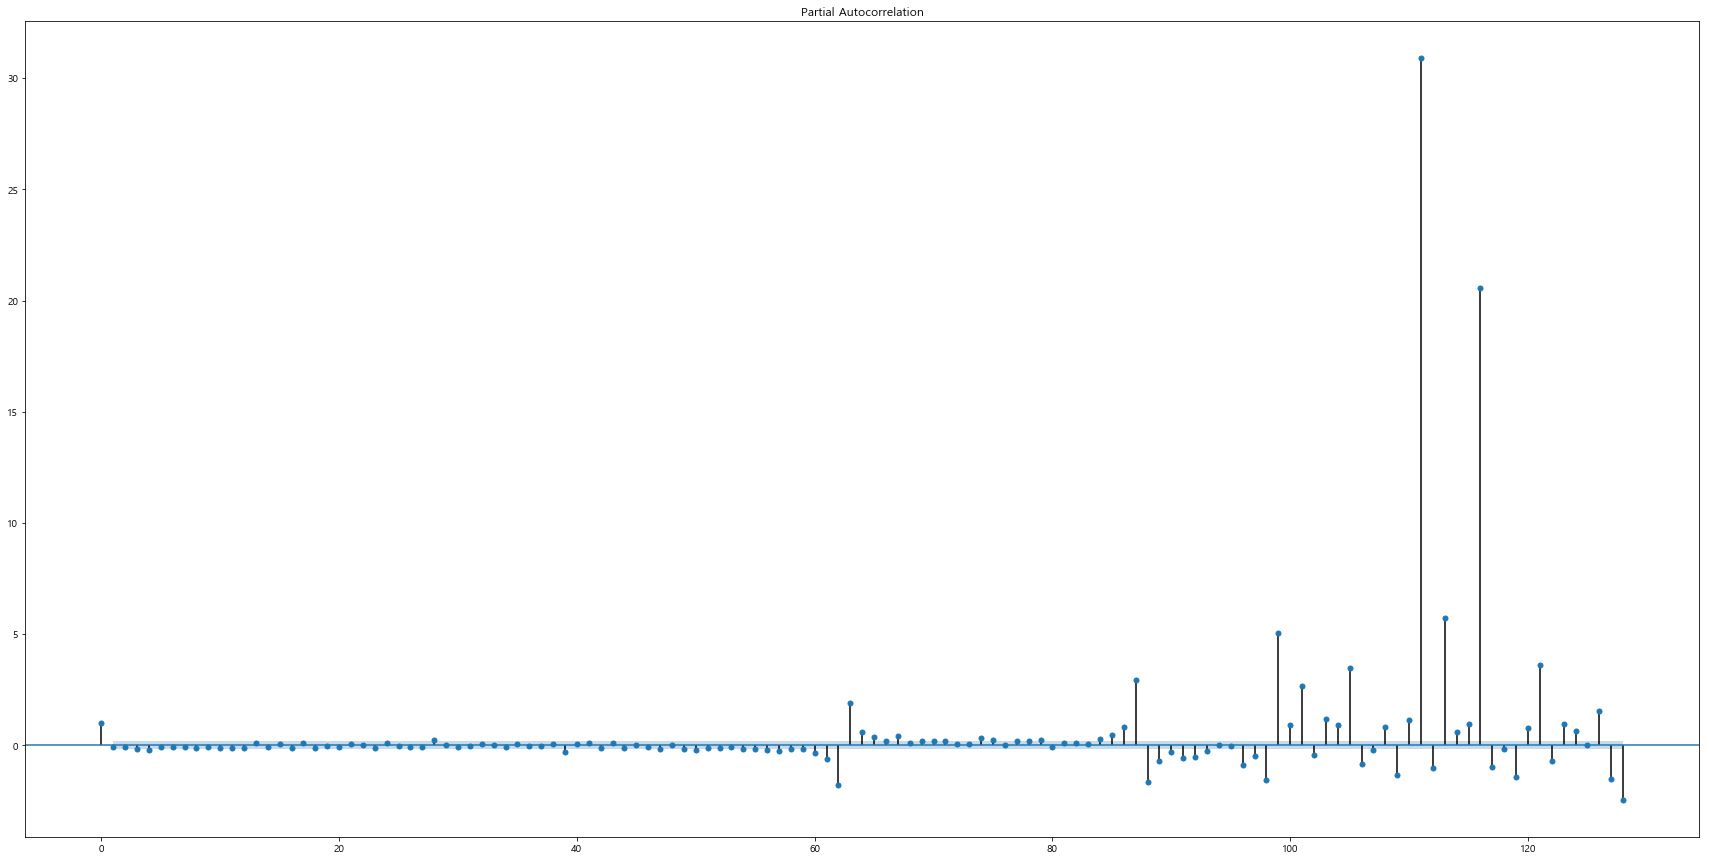

<Figure size 2160x2160 with 0 Axes>

In [9]:
countdiff_1=timecount_tsa.diff(periods=1).iloc[1:]    #1차 차분
countdiff_1.plot()
plot_acf(countdiff_1)
plot_pacf(countdiff_1)
plt.figure(figsize=(30,30))
plt.show()                                          #1차 차분했더니 나름 괜찮은데이터!(평균, 분산이 일정해보임)

## ARIMA

In [7]:
count_model= ARIMA(timecount_tsa, order=(1,1,0))     #arima에 적합시켜 모형 결정
count_model_fit= count_model.fit(trend='c', full_output=True, disp=1)
print(count_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.강서구   No. Observations:                  129
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -840.230
Method:                       css-mle   S.D. of innovations            163.115
Date:                Tue, 17 Dec 2019   AIC                           1686.459
Time:                        14:34:06   BIC                           1695.039
Sample:                    02-01-2009   HQIC                          1689.945
                         - 10-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.9045     13.562      0.214      0.831     -23.676      29.485
ar.L1.D.강서구    -0.0595      0.088     -0.675      0.501      -0.232       0.113
                                    Roots       

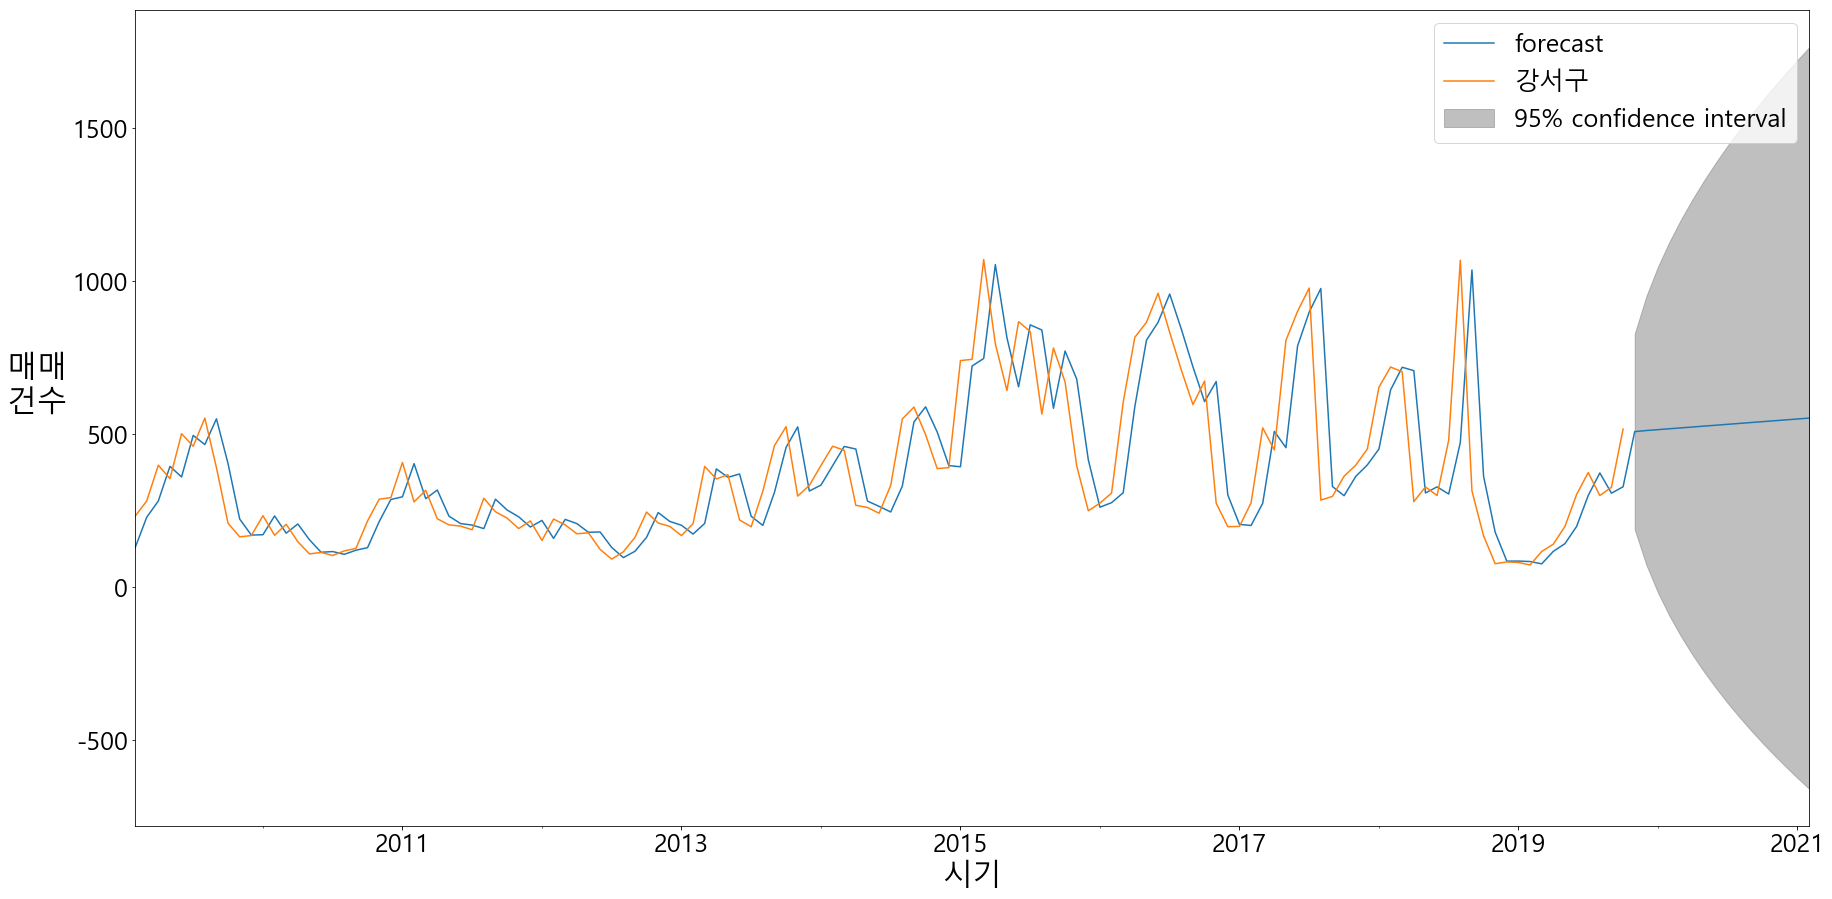

In [8]:
count_model_fit.plot_predict(1,145) # 아리마에 적합시킨 모형에 기반으로 미래의 값 예측
plt.xlabel("시기", fontsize=30)
plt.ylabel("매매      \n건수      ", fontsize=30, rotation=0)
plt.rc('font',size=25)
plt.savefig("./image/강서구/gangseo_count_arima.png", dpi=100)
plt.show()

In [15]:
cfore= count_model_fit.forecast(steps=12)
print(cfore)    # 아리마에 적합시킨 모형에 기반으로 미래의 값 예측

(array([508.76558653, 512.33320719, 515.19818492, 518.10499503,
       521.00931461, 523.91378247, 526.8182415 , 529.72270105,
       532.62716057, 535.5316201 , 538.43607963, 541.34053915]), array([163.11510655, 223.91807138, 271.75317187, 312.32942673,
       348.20997423, 380.72386836, 410.67157677, 438.57909646,
       464.81405288, 489.64536519, 513.27679039, 535.86709495]), array([[ 189.06585235,  828.4653207 ],
       [  73.4618518 ,  951.20456258],
       [ -17.42824462, 1047.82461447],
       [ -94.04943267, 1130.25942272],
       [-161.46969394, 1203.48832315],
       [-222.29128758, 1270.11885251],
       [-278.08325844, 1331.71974143],
       [-329.87653239, 1389.32193449],
       [-378.39164257, 1443.64596372],
       [-424.15566087, 1495.21890107],
       [-467.56794363, 1544.44010288],
       [-508.93966744, 1591.62074575]]))


## Time and Price

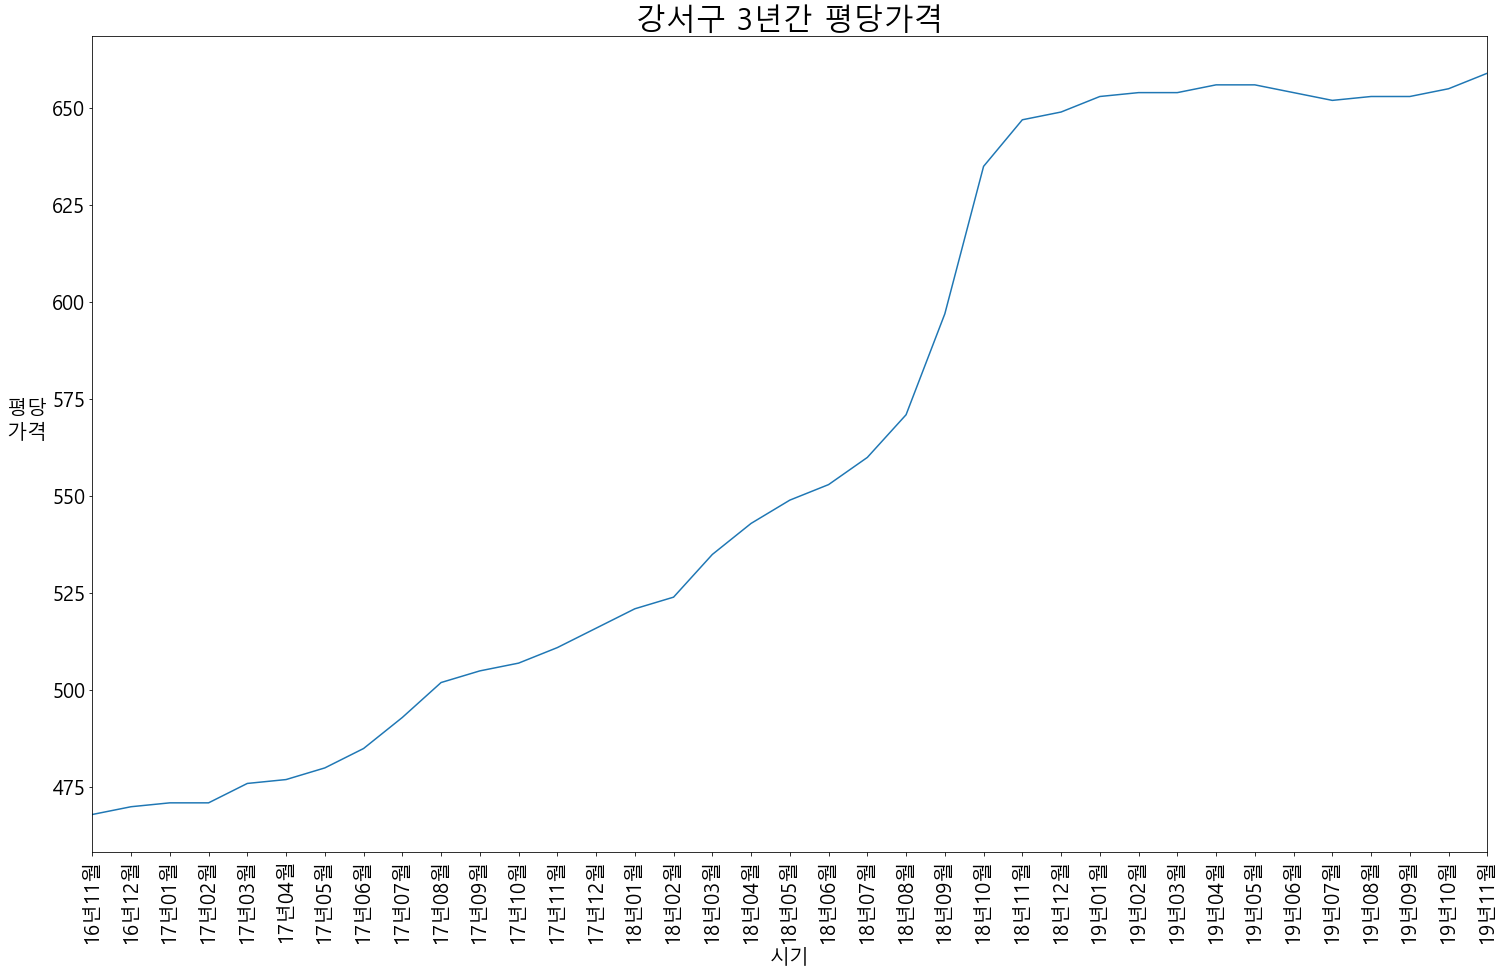

In [9]:
#평당가격 그래프 (시기, 평당가격)
plt.figure(figsize=(25,15))
plt.xlabel("시기", fontsize=20)
plt.ylabel("평당      \n가격      ", fontsize=20, rotation=0)
timeprice=pd.read_csv("timeprice.csv", index_col=0)
plt.plot(timeprice["강서구"])
plt.title("강서구 3년간 평당가격", fontsize=30)
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.xlim("16년11월","19년11월")
plt.savefig("./image/강서구/gangseo_price_graph.png", dpi=300)
plt.show()

## TSA (time and price)

<Figure size 864x720 with 0 Axes>

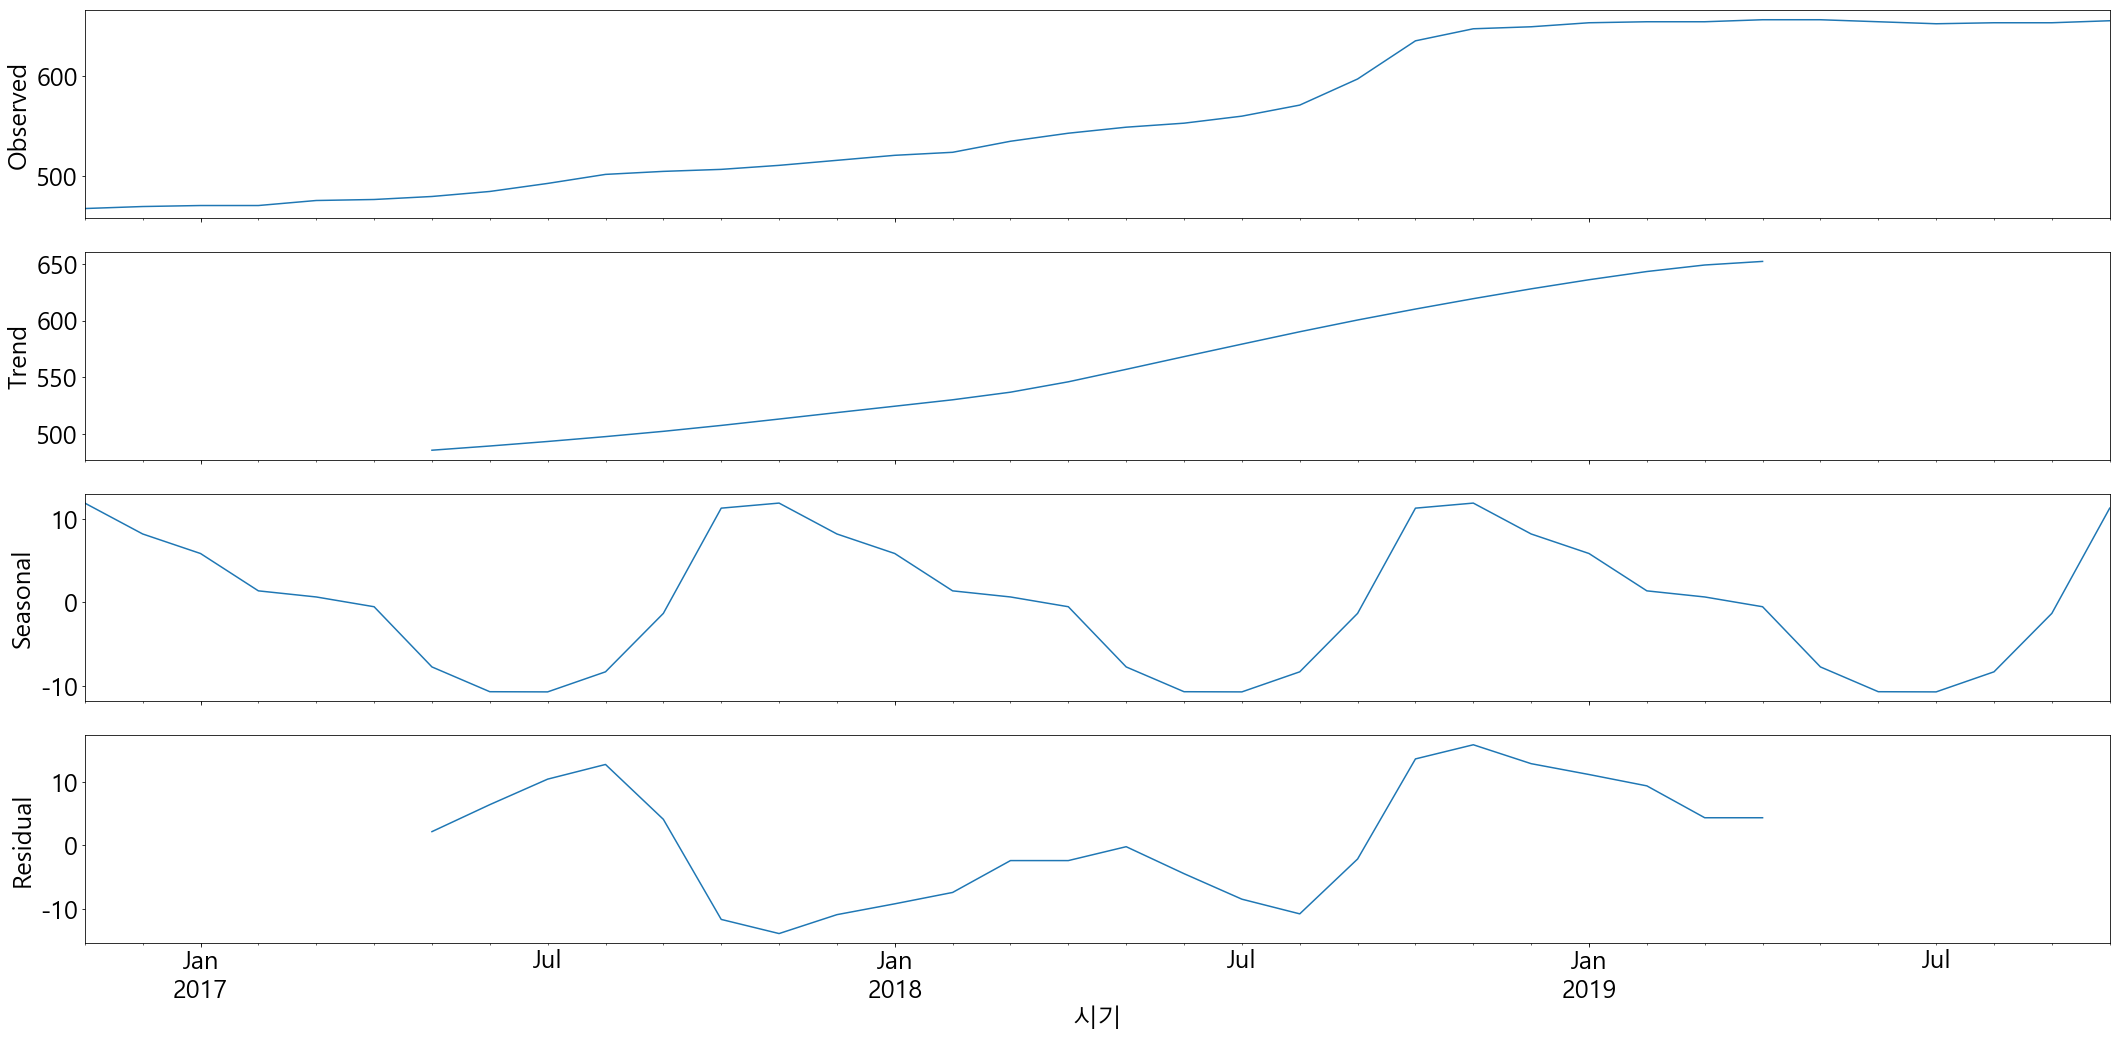

In [10]:
# 계절성, 추세 그래프 ()  면적당 가격
#result = seasonal_decompose(b, model='additive')
#result.plot()
timepricenum=pd.read_csv("timepricenum.csv", header=0, index_col=0, squeeze=True)
timepricenum.reset_index(inplace=True)
timepricenum['시기'] = pd.to_datetime(timepricenum['시기'], format='%Y%m')
timepricenum = timepricenum.set_index('시기')                               #여기까지 파일 읽어서 인덱스 날짜형으로 지정해주기

timeprice_tsa= timepricenum["강서구"]                                    
s=sm.tsa.seasonal_decompose(timeprice_tsa)         #그래프(데이터, 추세요인, 계절요인, 불규칙요인) 그리기 (분해시계열!!)
matplotlib.rcParams['axes.unicode_minus'] = False 
plt.rc('font',size=25)
plt.figure(figsize=(12,10))
s.plot()
plt.savefig("./image/강서구/gangseo_price_tsa.png", dpi=100)
plt.show()

## acf and pacf

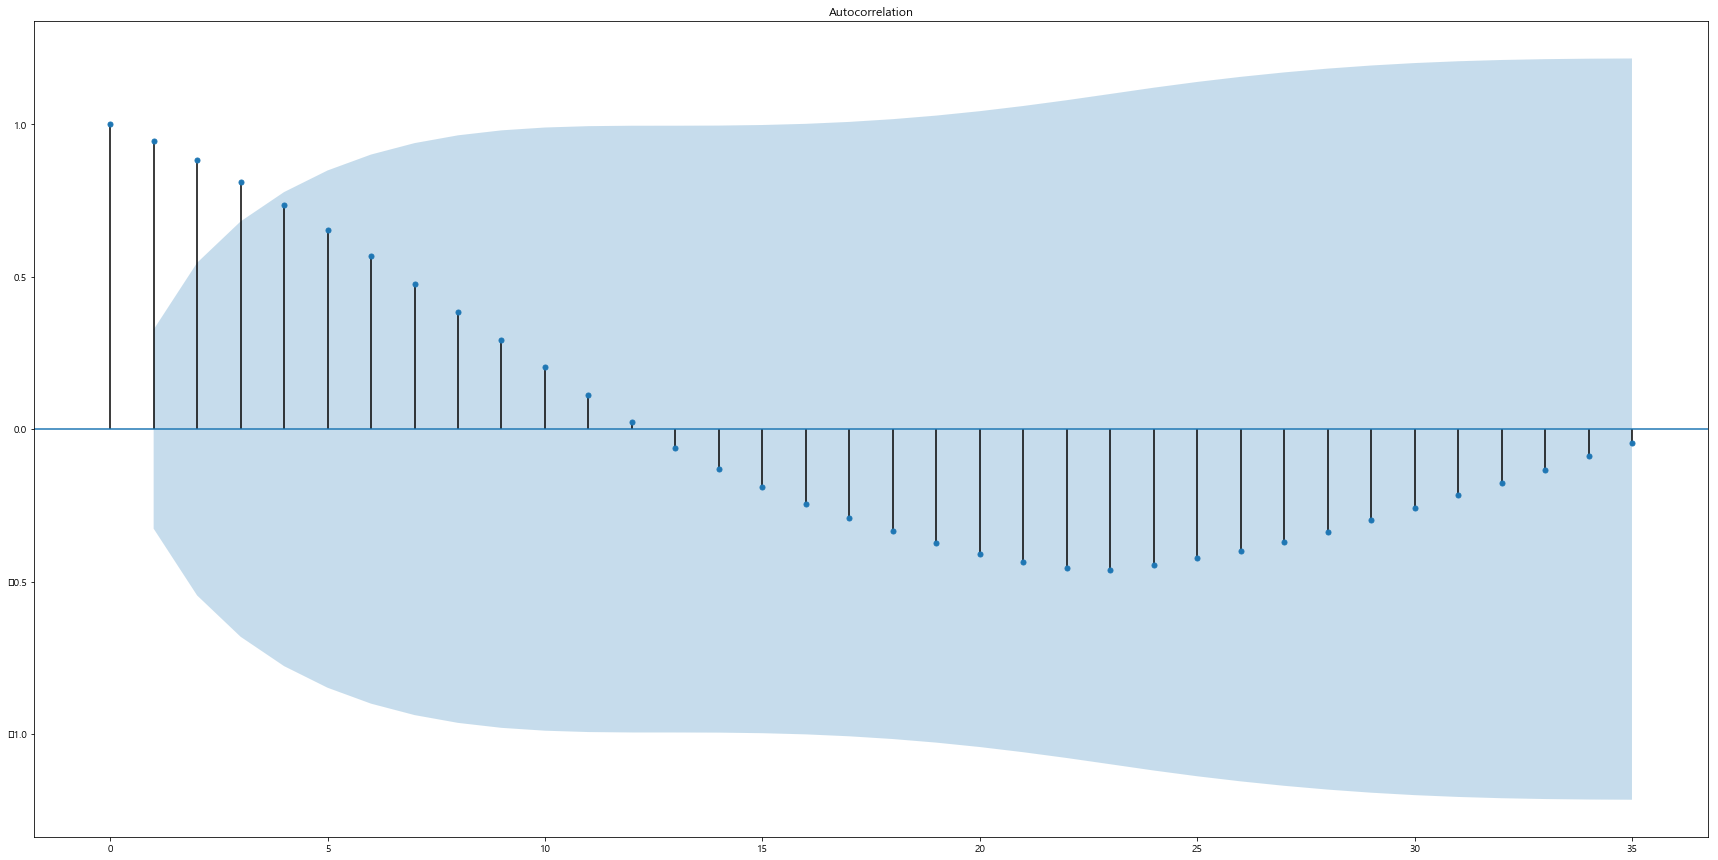

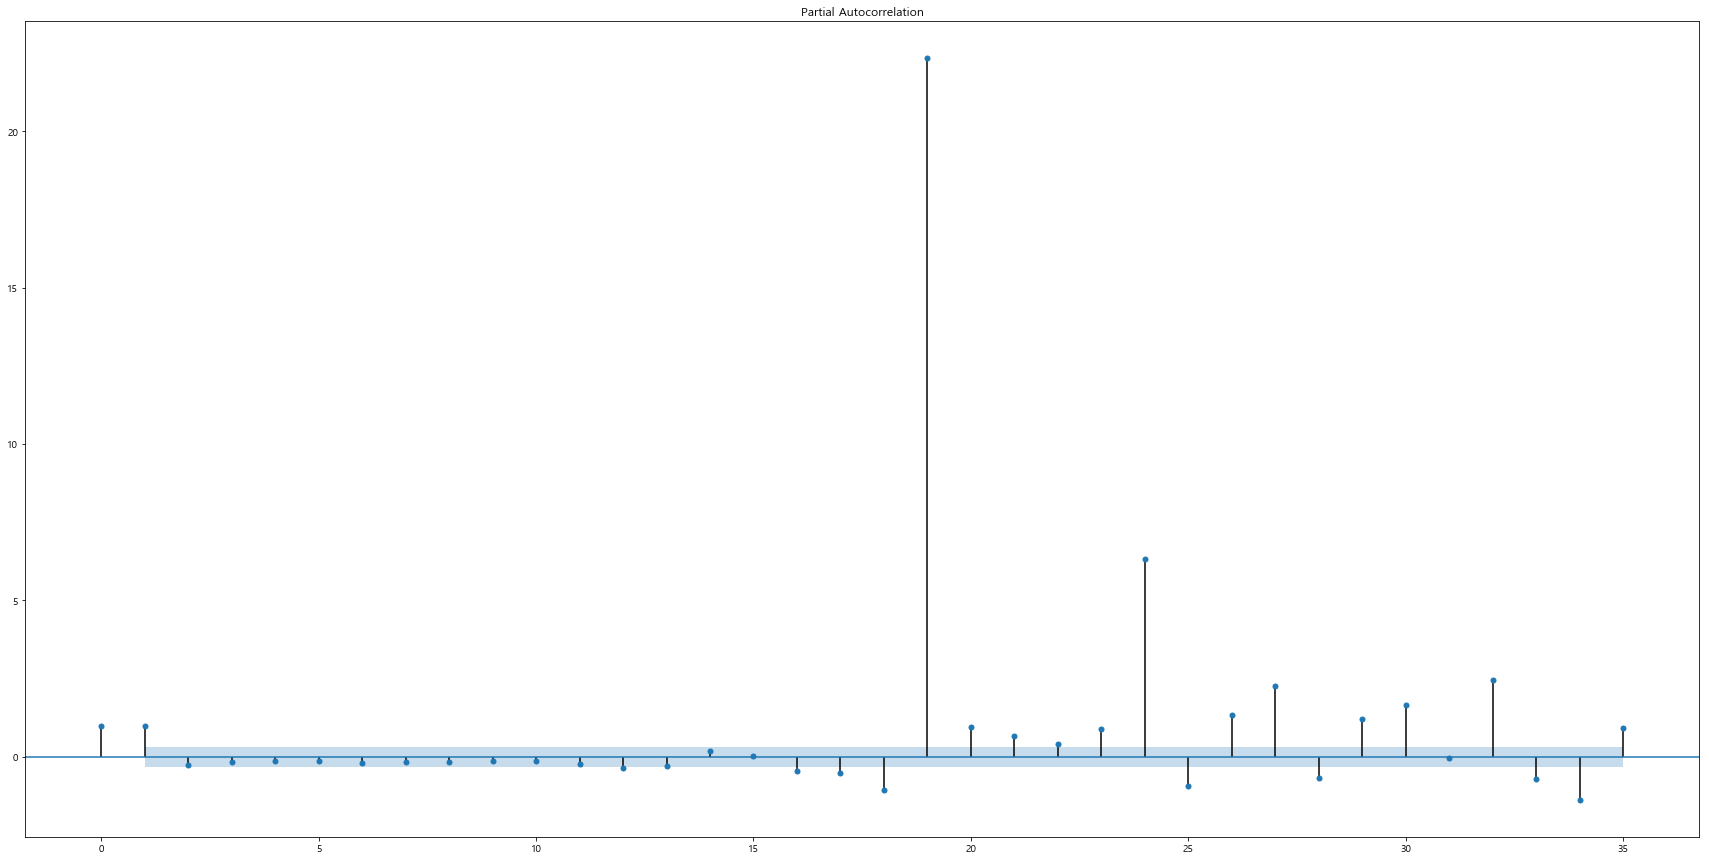

In [18]:
plot_acf(timeprice_tsa)    #acf 그래프 (자기상관함수)
plot_pacf(timeprice_tsa)   #pacf 그래프 (부분자기상관함수)
plt.show()

## First Differencing

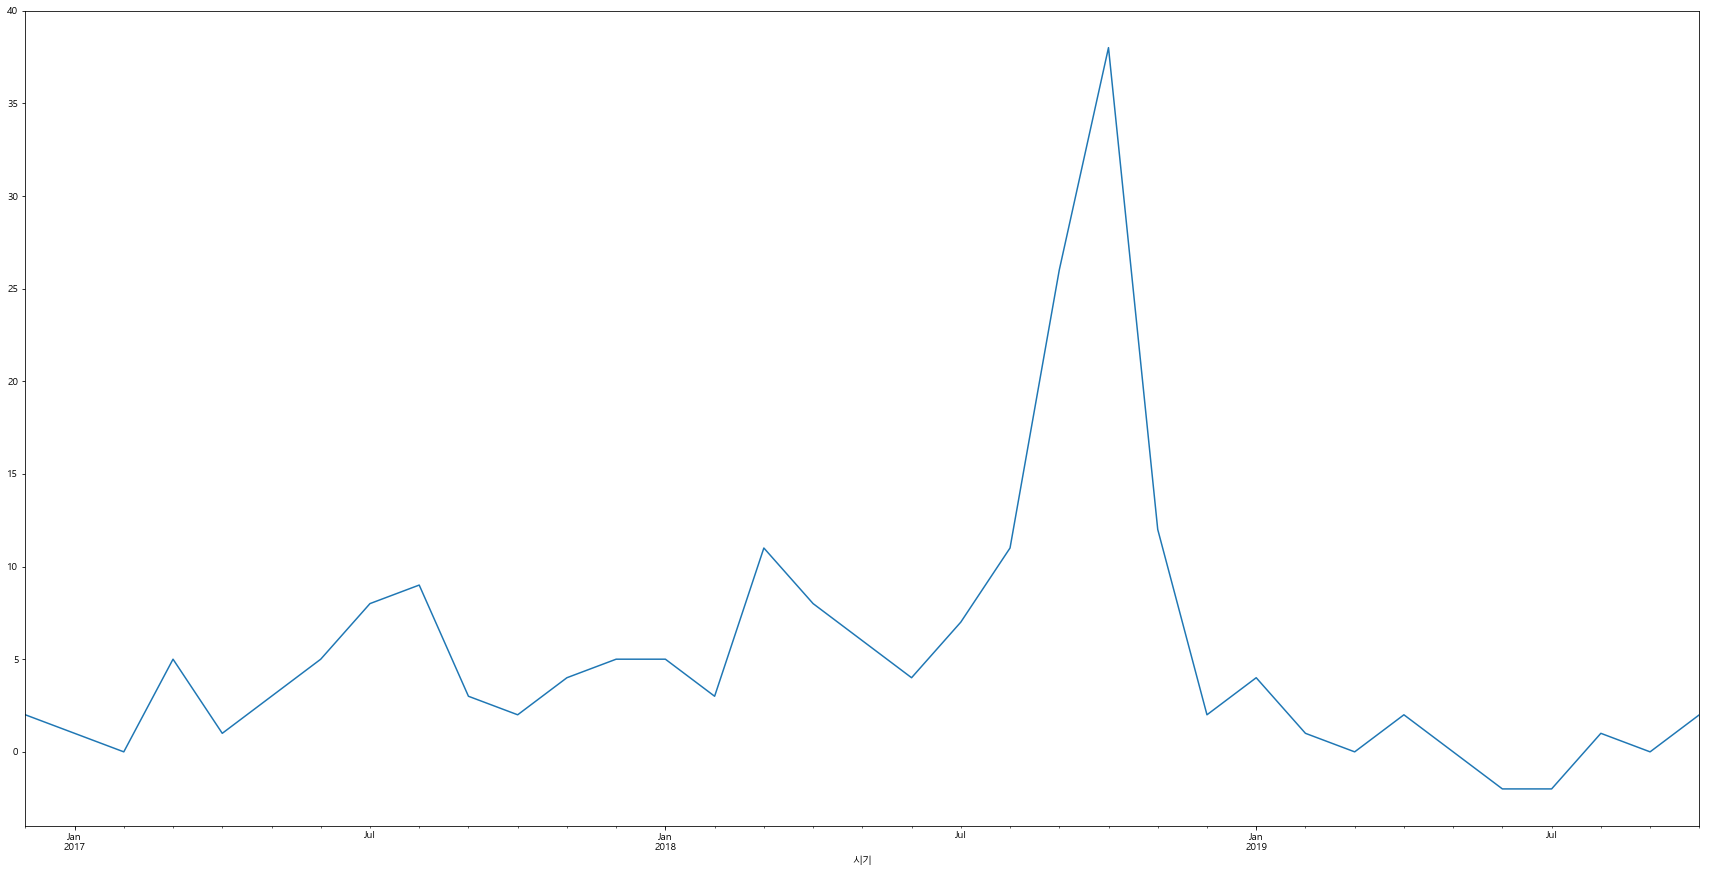

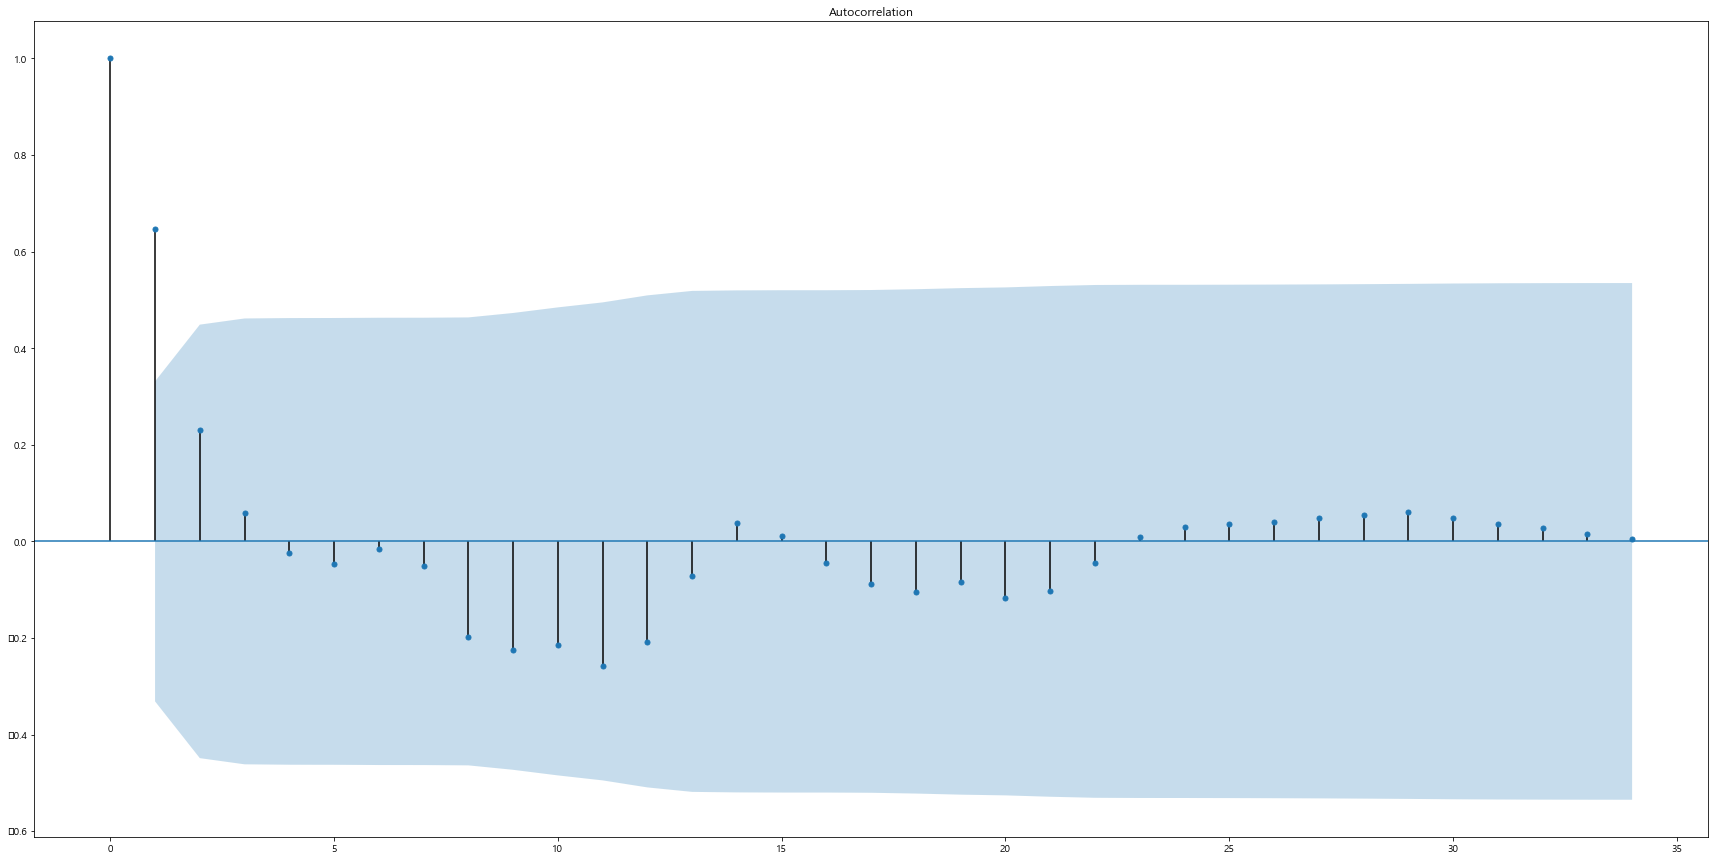

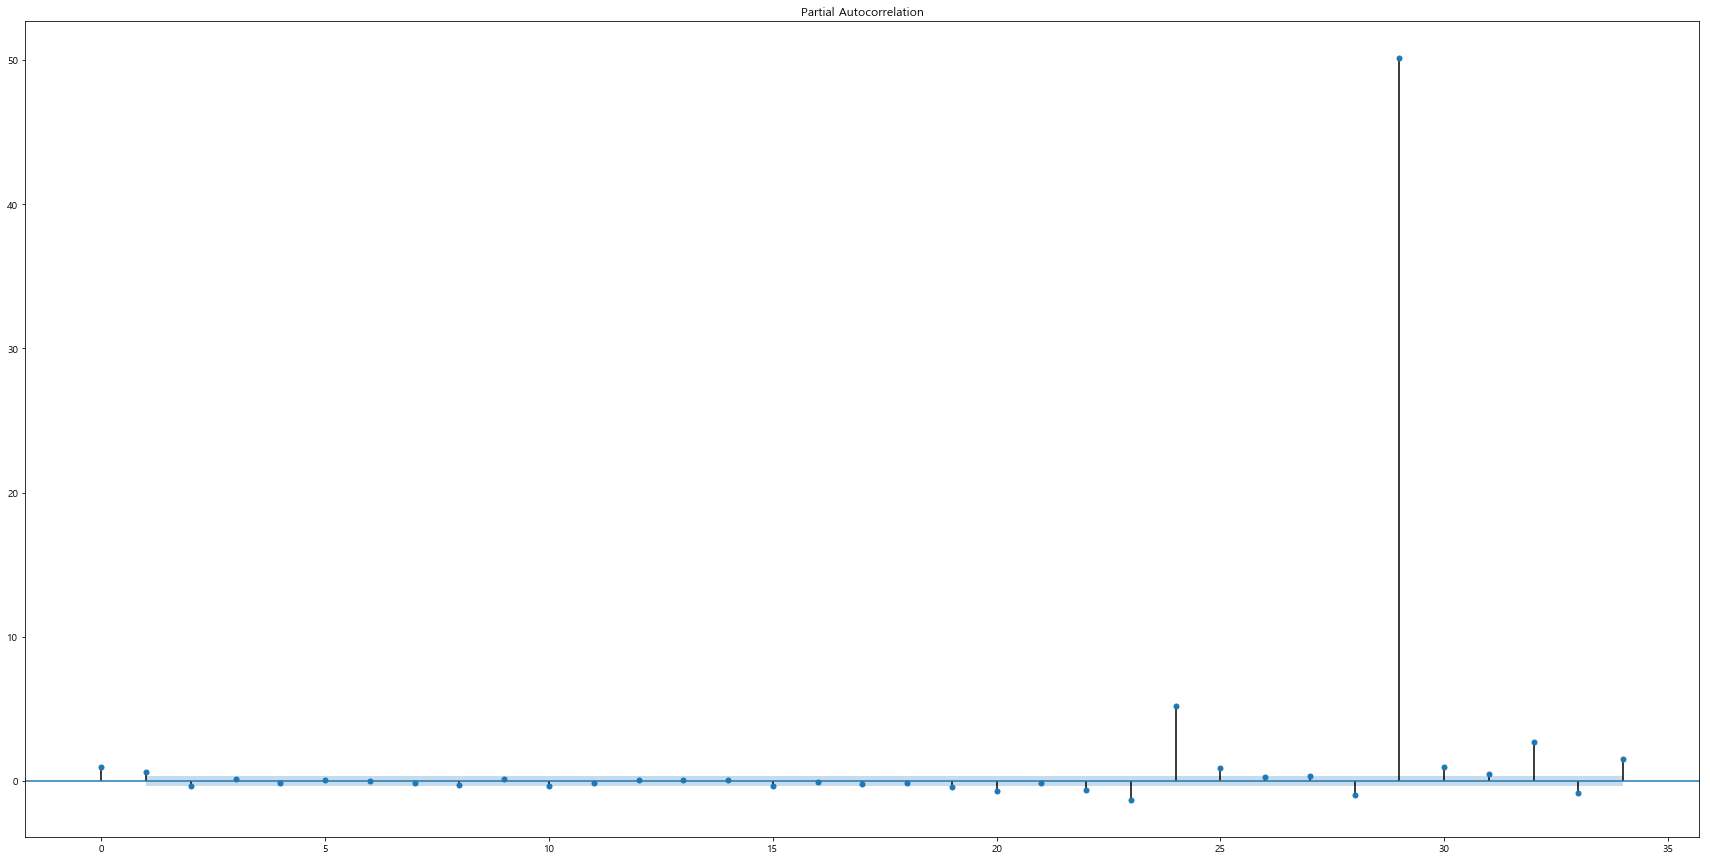

<Figure size 2160x2160 with 0 Axes>

In [19]:
price_diff_1=timeprice_tsa.diff(periods=1).iloc[1:]    #1차 차분
price_diff_1.plot()
plot_acf(price_diff_1)
plot_pacf(price_diff_1)
plt.figure(figsize=(30,30))
plt.show()                                          #1차 차분했더니 나름 괜찮은데이터!(평균, 분산이 일정해보임)

## ARIMA

In [11]:
price_model= ARIMA(timeprice_tsa, order=(1,1,0))     #arima에 적합시켜 모형 결정
price_model_fit= price_model.fit(trend='nc', full_output=True, disp=1)
print(price_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.강서구   No. Observations:                   35
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -112.478
Method:                       css-mle   S.D. of innovations              5.948
Date:                Tue, 17 Dec 2019   AIC                            228.957
Time:                        14:35:18   BIC                            232.068
Sample:                    12-01-2016   HQIC                           230.031
                         - 10-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.D.강서구     0.7482      0.104      7.202      0.000       0.545       0.952
                                    Roots                                    
                  Real          Imaginary         

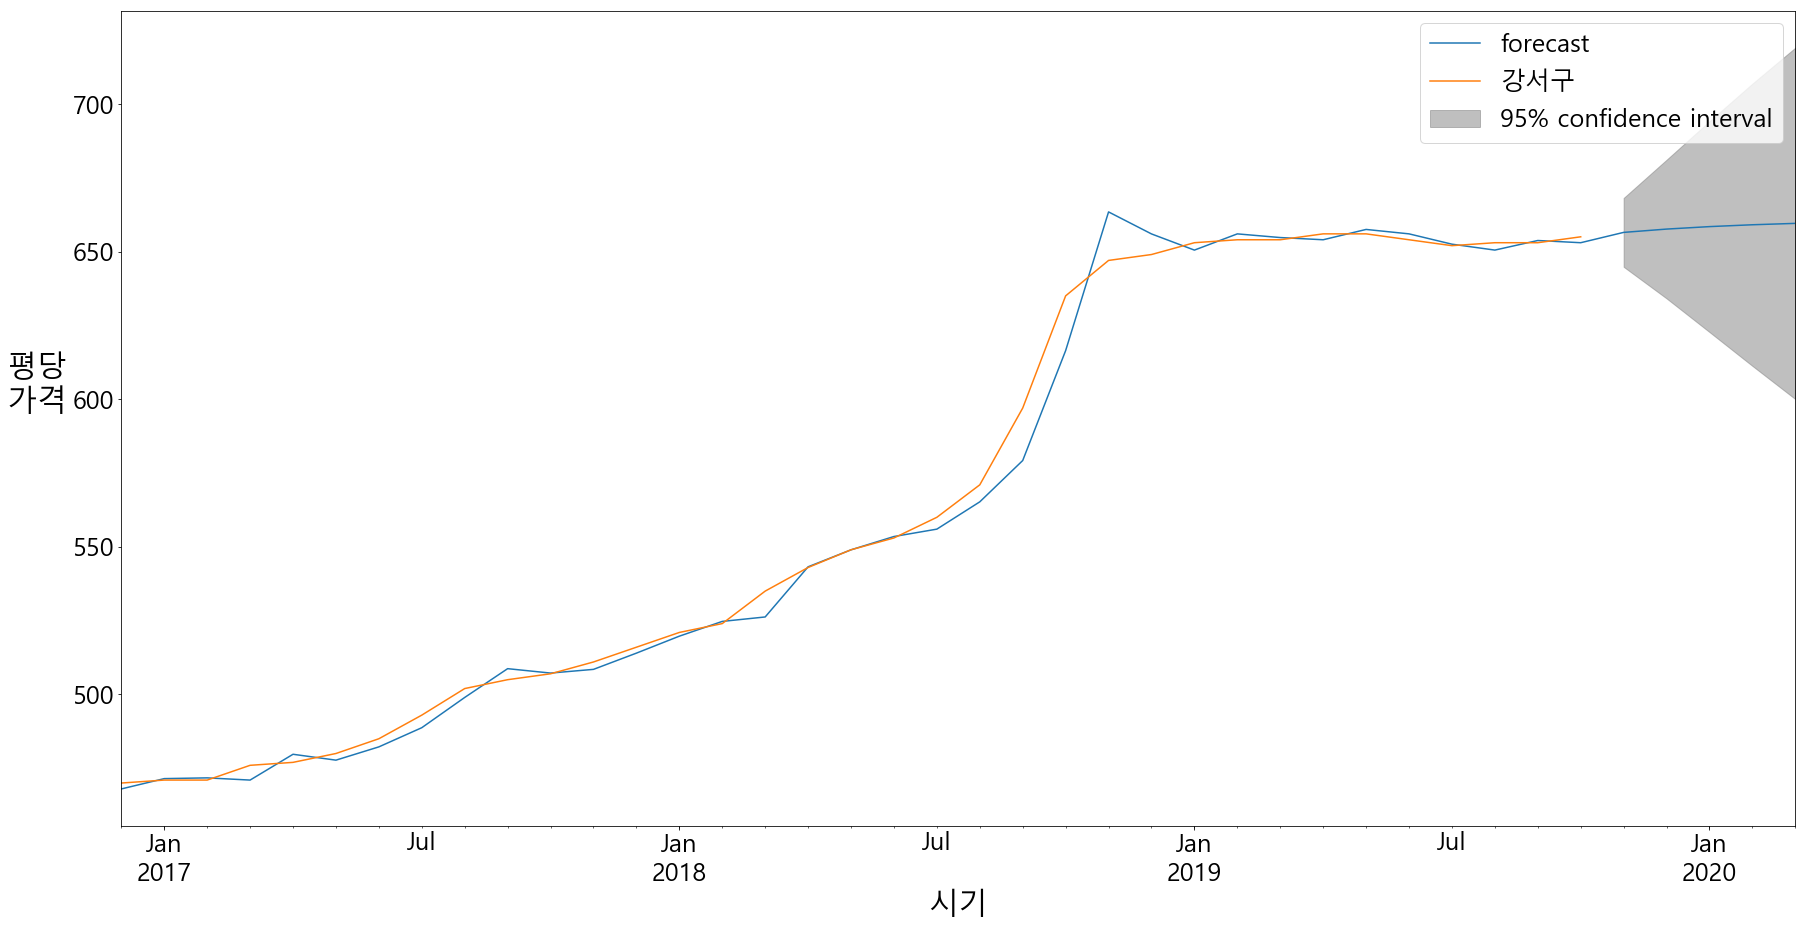

In [12]:
price_model_fit.plot_predict(1,40) # 아리마에 적합시킨 모형에 기반으로 미래의 값 예측
plt.xlabel("시기", fontsize=30)
plt.ylabel("평당      \n가격      ", fontsize=30, rotation=0)
plt.rc('font',size=25)
plt.savefig("./image/강서구/gangseo_price_arima.png", dpi=100)
plt.show()

In [22]:
pfore= price_model_fit.forecast(steps=12)
print(pfore)    # 아리마에 적합시킨 모형에 기반으로 미래의 값 예측

(array([656.49641244, 657.61603754, 658.453748  , 659.08052818,
       659.54948901, 659.90036842, 660.16289857, 660.35932527,
       660.50629295, 660.61625507, 660.69852942, 660.7600876 ]), array([ 5.94773323, 11.97877752, 18.21907835, 24.392246  , 30.36387609,
       36.07395802, 41.50220071, 46.6496171 , 51.52832742, 56.15578408,
       60.55148392, 64.73511982]), array([[644.83906953, 668.15375535],
       [634.13806502, 681.09401006],
       [622.74501061, 694.16248539],
       [611.27260452, 706.88845184],
       [600.03738544, 719.06159258],
       [589.19670992, 730.60402692],
       [578.8200799 , 741.50571725],
       [568.92775586, 751.79089468],
       [559.51262702, 761.49995887],
       [550.55294075, 770.6795694 ],
       [542.01980173, 779.37725711],
       [533.88158421, 787.63859099]]))


## Polynomial Regression Analysis (District and floor)

In [13]:
# 지역별로, 층별로 다항회귀분석 (면적, 매매가격)
disflo=naver[naver['지역']=="강서구"] #전체데이터에서 강남구 데이터만 가져와서 데이터프레임으로 저장
disflo1=naver[(naver['지역']=="강서구") & (naver['현재층범주']==1)] #전체데이터에서 강남구, 층값이 1인것만 df로 저장
disflo2=naver[(naver['지역']=="강서구") & (naver['현재층범주']==2)] #전체데이터에서 강남구, 층값이 2인것만 df로 저장
disflo3=naver[(naver['지역']=="강서구") & (naver['현재층범주']==3)] #전체데이터에서 강남구, 층값이 3인것만 df로 저장
disflo4=naver[(naver['지역']=="강서구") & (naver['현재층범주']==4)] #전체데이터에서 강남구, 층값이 4인것만 df로 저장
disflo5=naver[(naver['지역']=="강서구") & (naver['현재층범주']==5)] #전체데이터에서 강남구, 층값이 5인것만 df로 저장

#disflo1 : sm.OLS.from_formula.fit가 회귀 모형 만들어주는 함수. y값이 가격이고 x값이 면적인데, 둘 사이의 관계를 선형으로 나타내는것보다
# 비선형으로 나타내는 것이 더 적합하다고 분석해서(r로) 2차 함수로 나타냄
# sm.OLS.from_formula.fit.summary()는 회귀분석의 결과(적합하다고 할 수 있는지와, 회귀모형 함수) 확인
# 적합성은 r-squared, p-value등으로 확인
disflomodel1 = sm.OLS.from_formula("매물가 ~ 전용면적", data=disflo1).fit()
print(disflomodel1.summary())

#disflo2
disflomodel2 = sm.OLS.from_formula("매물가 ~ 전용면적", data=disflo2).fit()
print(disflomodel2.summary())

#disflo3
disflomodel3 = sm.OLS.from_formula("매물가 ~ 전용면적", data=disflo3).fit()
print(disflomodel3.summary())

#disflo4
disflomodel4 = sm.OLS.from_formula("매물가 ~ 전용면적", data=disflo4).fit()
print(disflomodel4.summary())

#disflo5
disflomodel5 = sm.OLS.from_formula("매물가 ~ 전용면적", data=disflo5).fit()
print(disflomodel5.summary())


#model1.params는 회귀분석 결과 함수의 계수를 나타냄. [0]은 절편, [1]은 1차항의 계수, [2]는 2차항의 계수 ...
def modelfun1(x):
    return disflomodel1.params[0]+disflomodel1.params[1]*x #+ disflomodel1.params[2]*x*x

def modelfun2(x):
    return disflomodel2.params[0]+disflomodel2.params[1]*x #+ disflomodel2.params[2]*x*x

def modelfun3(x):
    return disflomodel3.params[0]+disflomodel3.params[1]*x #+ disflomodel3.params[2]*x*x

def modelfun4(x):
    return disflomodel4.params[0]+disflomodel4.params[1]*x #+ disflomodel4.params[2]*x*x

def modelfun5(x):
    return disflomodel5.params[0]+disflomodel5.params[1]*x #+ disflomodel5.params[2]*x*x



#x에 10부터 320까지 0,1간격으로 집어넣음.
#X(면적)값에 대해서 회귀식에 적합시켜봄. =>y(집값)의 예측값이 나옴
X=[]
floor1=[]
floor2=[]
floor3=[]
floor4=[]
floor5=[]
for x in list(np.arange(10, 192, 0.1)):
    X.append(x)
    floor1.append(modelfun1(x))
    floor2.append(modelfun2(x))
    floor3.append(modelfun3(x))
    floor4.append(modelfun4(x))
    floor5.append(modelfun5(x))

#x값과, 층수가 1일때의 예측값, 2일때, 3일때, 4일때, 5일때 예측값을 하나의 df에 집어넣음     
reg=pd.DataFrame({'X' : X, 'floor1' : floor1,  'floor2' : floor2,  'floor3' : floor3,  'floor4' : floor4, 'floor5' : floor5})

                            OLS Regression Results                            
Dep. Variable:                    매물가   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     178.4
Date:                Tue, 17 Dec 2019   Prob (F-statistic):           8.60e-32
Time:                        14:35:41   Log-Likelihood:                -3168.7
No. Observations:                 281   AIC:                             6341.
Df Residuals:                     279   BIC:                             6349.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.471e+04   3539.125      6.982      0.0

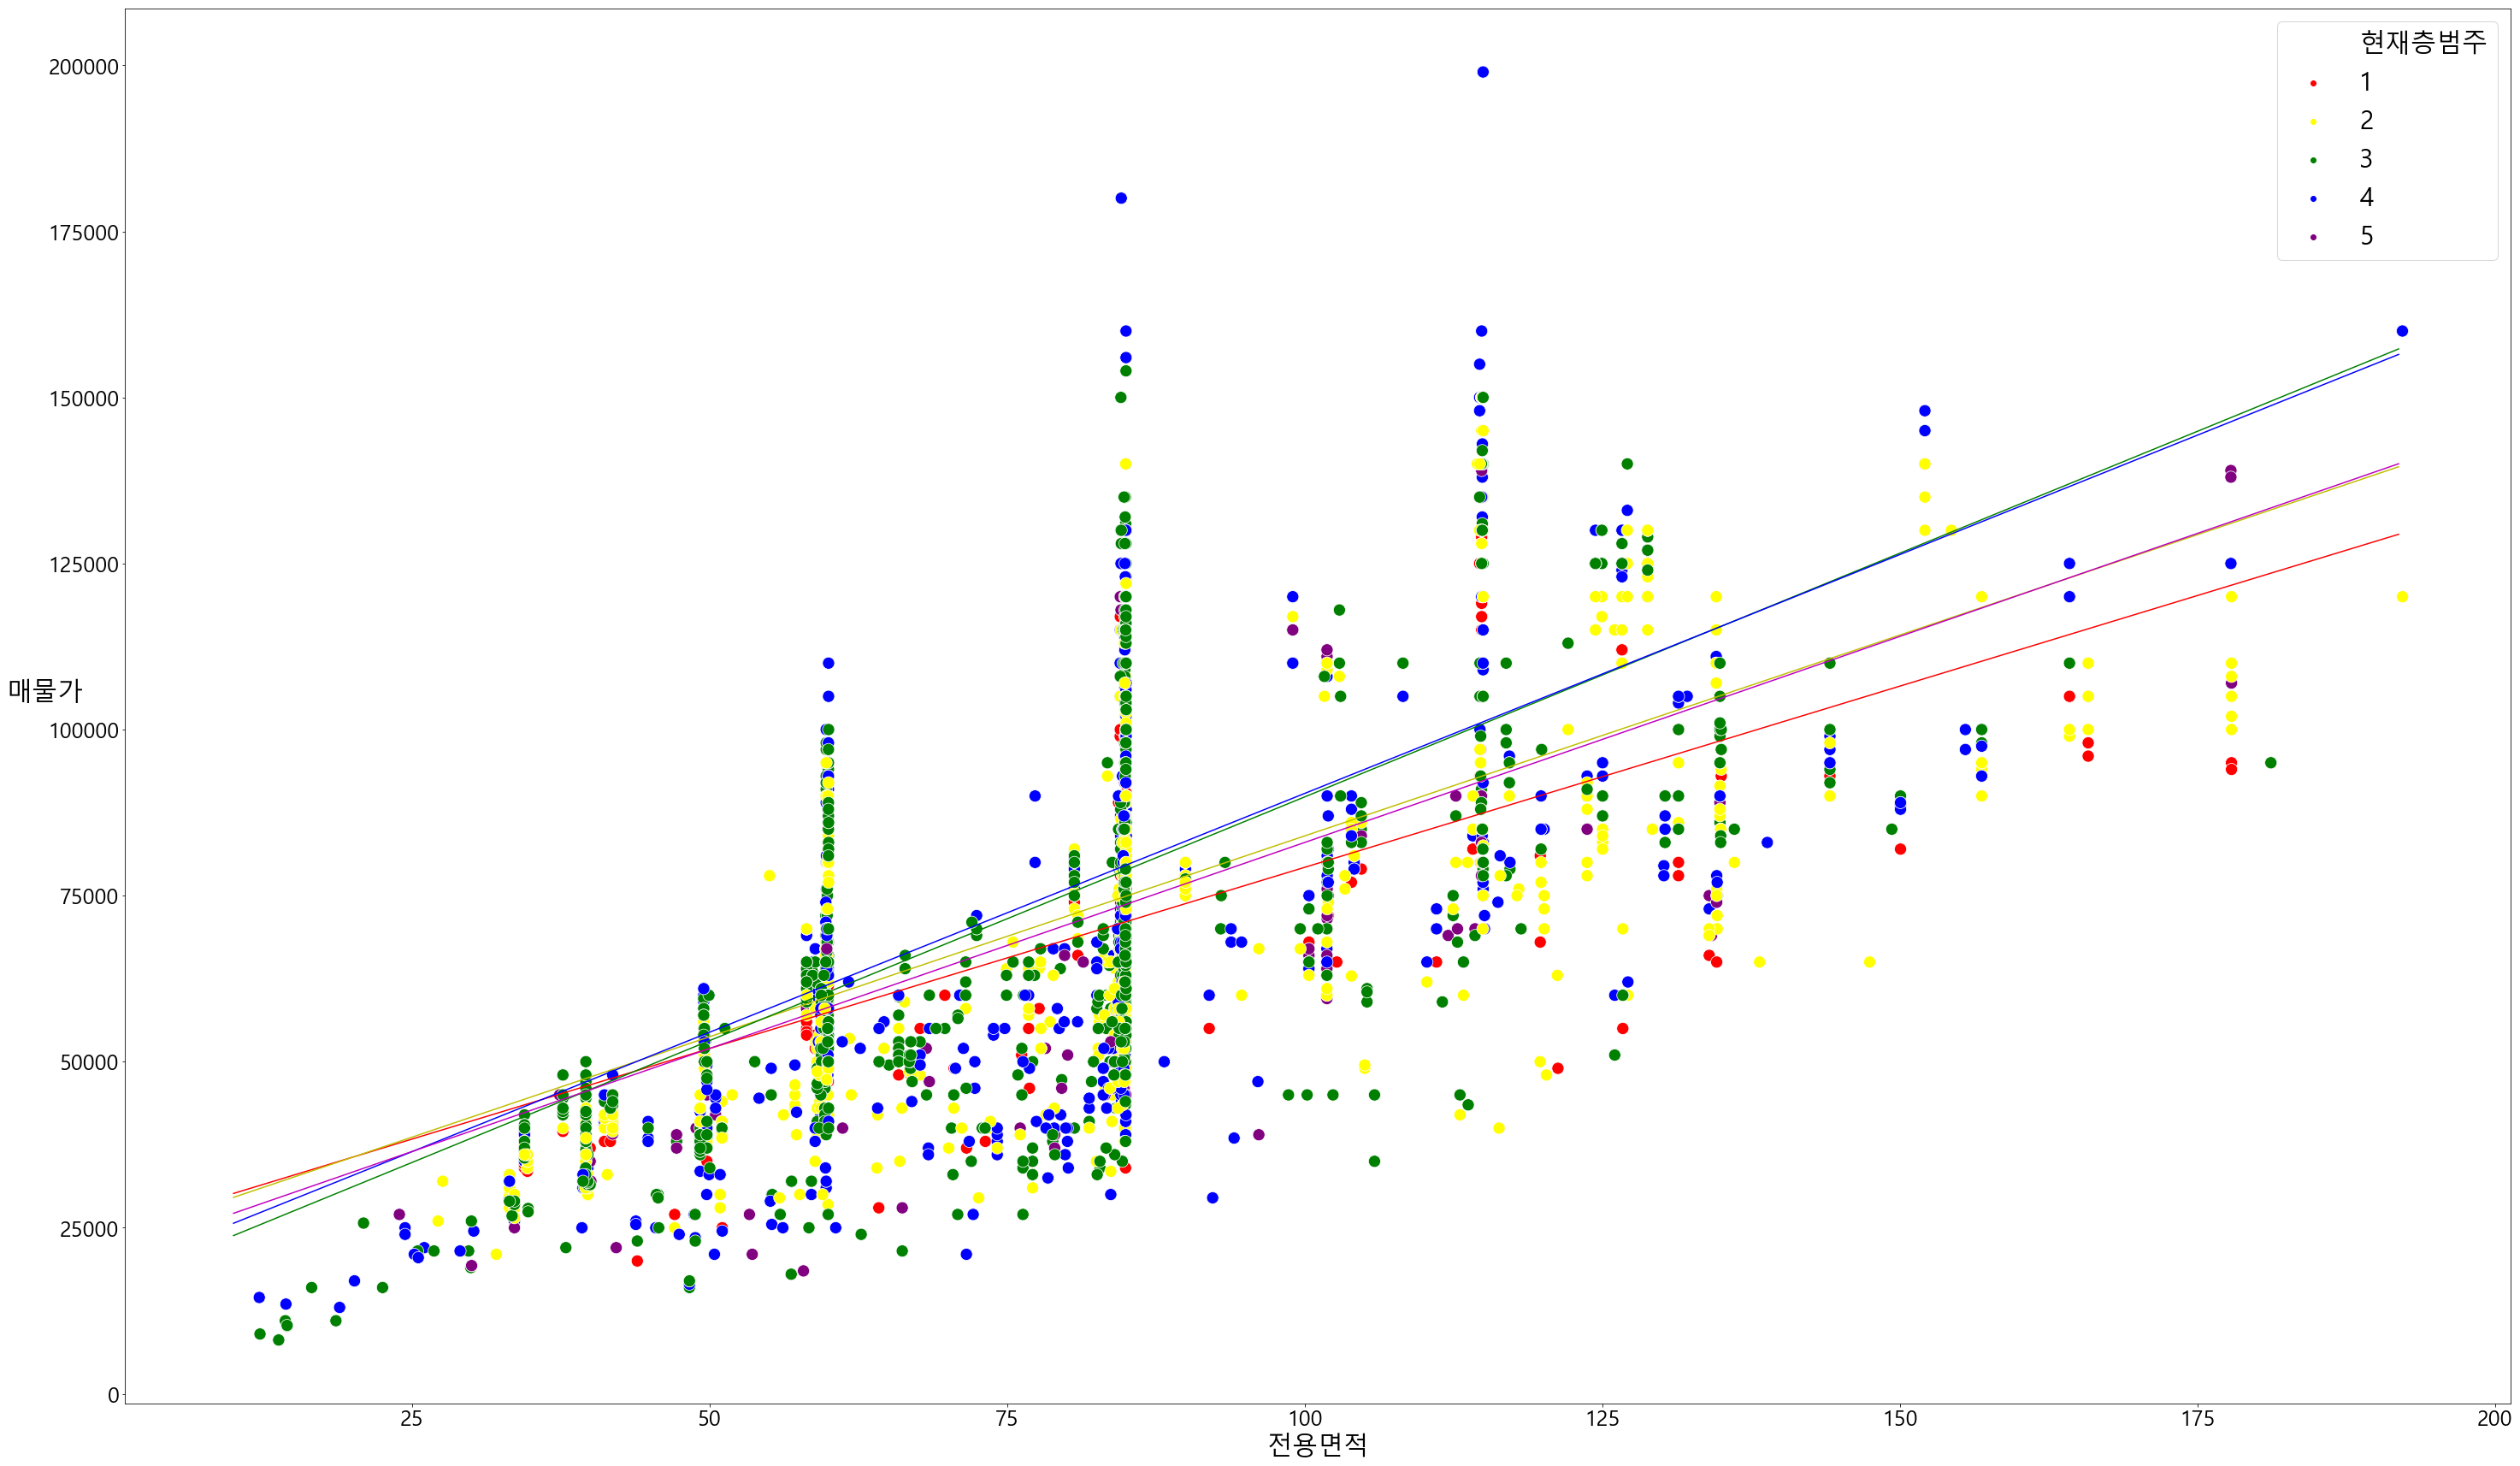

In [14]:
plt.figure(figsize=(50,30))
plt.rc('legend',fontsize=30) 
plt.xlabel("전용면적", fontsize=30)
plt.ylabel("매물가", fontsize=30, rotation=0)
sns.scatterplot(x='전용면적',y='매물가',hue='현재층범주',s=200,data=disflo, palette=['red','yellow','green','blue','purple'], legend='full')
plt.plot(reg.X, reg.floor1, "r-") 
plt.plot(reg.X, reg.floor2, "y-") 
plt.plot(reg.X, reg.floor3, "g-") 
plt.plot(reg.X, reg.floor4, "b-") 
plt.plot(reg.X, reg.floor5, "m-") 
plt.savefig("./image/강서구/gangseo_reg.png", dpi=100)
plt.show()